#*IMPORTS AND SETUP*

In [19]:
!pip install -q datasets
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q matplotlib seaborn
!pip install -q opencv-python
!pip install -q tqdm

In [20]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, applications, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import cv2
import glob
from tqdm import tqdm
from google.colab import drive
import zipfile
import requests
from datasets import load_dataset
import shutil

In [21]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [22]:
# Mount Google Drive
drive.mount('/content/drive')

# Create a directory for datasets
if not os.path.exists('/content/dataset'):
    os.makedirs('/content/dataset')
    os.makedirs('/content/dataset/train')
    os.makedirs('/content/dataset/val')
    os.makedirs('/content/dataset/test')

# Configuration parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.0001
NUM_CLASSES = 2  # Binary classification: real vs AI-generated

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#*DATASET PREPARATION*

In [23]:
def prepare_real_ghibli_images():
    """
    Downloads and prepares the real Ghibli images dataset from Huggingface.
    """
    print("Preparing real Ghibli images dataset...")

    # Load the dataset from Huggingface
    ghibli_dataset = load_dataset("satyamtripathii/Ghibli_Anime")

    # Create directories for real Ghibli images
    real_ghibli_train_dir = '/content/dataset/train/real_ghibli'
    real_ghibli_val_dir = '/content/dataset/val/real_ghibli'
    real_ghibli_test_dir = '/content/dataset/test/real_ghibli'

    os.makedirs(real_ghibli_train_dir, exist_ok=True)
    os.makedirs(real_ghibli_val_dir, exist_ok=True)
    os.makedirs(real_ghibli_test_dir, exist_ok=True)

    # Split the dataset
    train_size = int(0.7 * len(ghibli_dataset['train']))
    val_size = int(0.15 * len(ghibli_dataset['train']))
    test_size = len(ghibli_dataset['train']) - train_size - val_size

    # Save images to appropriate directories
    for i, example in enumerate(tqdm(ghibli_dataset['train'])):
        try:
            img = example['image']

            # Convert to RGB mode if it's not already in RGB mode
            if img.mode != 'RGB':
                img = img.convert('RGB')

            if i < train_size:
                img.save(f"{real_ghibli_train_dir}/real_ghibli_{i}.jpg")
            elif i < train_size + val_size:
                img.save(f"{real_ghibli_val_dir}/real_ghibli_{i}.jpg")
            else:
                img.save(f"{real_ghibli_test_dir}/real_ghibli_{i}.jpg")
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            continue

    print(f"Saved {train_size} real Ghibli images for training")
    print(f"Saved {val_size} real Ghibli images for validation")
    print(f"Saved {test_size} real Ghibli images for testing")


def prepare_ai_generated_images():
    """
    Prepares the AI-generated Ghibli images from Hugging Face.
    """
    print("Preparing AI-generated Ghibli images dataset...")

    # Load the dataset from Huggingface
    ai_generated_dataset = load_dataset("filberthamijoyo/AI_Generated_Ghibli")

    # Create directories for AI-generated images
    ai_generated_train_dir = '/content/dataset/train/ai_generated'
    ai_generated_val_dir = '/content/dataset/val/ai_generated'
    ai_generated_test_dir = '/content/dataset/test/ai_generated'

    os.makedirs(ai_generated_train_dir, exist_ok=True)
    os.makedirs(ai_generated_val_dir, exist_ok=True)
    os.makedirs(ai_generated_test_dir, exist_ok=True)

    # Split the dataset
    train_size = int(0.7 * len(ai_generated_dataset['train']))
    val_size = int(0.15 * len(ai_generated_dataset['train']))

    # Save images to appropriate directories
    for i, example in enumerate(tqdm(ai_generated_dataset['train'])):
        try:
            img = example['image']

            # Convert to RGB mode if it's not already in RGB mode
            if img.mode != 'RGB':
                img = img.convert('RGB')

            if i < train_size:
                img.save(f"{ai_generated_train_dir}/ai_generated_{i}.jpg")
            elif i < train_size + val_size:
                img.save(f"{ai_generated_val_dir}/ai_generated_{i}.jpg")
            else:
                img.save(f"{ai_generated_test_dir}/ai_generated_{i}.jpg")
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            continue

    print(f"Saved {train_size} AI-generated images for training")
    print(f"Saved {val_size} AI-generated images for validation")
    print(f"Saved {len(ai_generated_dataset['train']) - train_size - val_size} AI-generated images for testing")

def setup_data_generators():
    """
    Sets up data generators for training, validation, and testing.
    Enhanced with more aggressive data augmentation.
    """
    global train_generator, validation_generator, test_generator, CLASS_NAMES

    # Directory setup
    base_dir = '/content/dataset'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    # Get class names
    CLASS_NAMES = sorted(os.listdir(train_dir))
    print(f"Found {NUM_CLASSES} classes: {CLASS_NAMES}")

    # Count the number of files in each class directory for verification
    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        if os.path.isdir(class_path):
            num_files = len(os.listdir(class_path))
            print(f"Train - {class_dir}: {num_files} images")

    for class_dir in os.listdir(val_dir):
        class_path = os.path.join(val_dir, class_dir)
        if os.path.isdir(class_path):
            num_files = len(os.listdir(class_path))
            print(f"Validation - {class_dir}: {num_files} images")

    # More aggressive data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,  # Increased from 20
        width_shift_range=0.3,  # Increased from 0.2
        height_shift_range=0.3,  # Increased from 0.2
        shear_range=0.3,  # Increased from 0.2
        zoom_range=0.3,  # Increased from 0.2
        horizontal_flip=True,
        vertical_flip=True,  # Added vertical flip
        brightness_range=[0.7, 1.3],  # Added brightness variation
        channel_shift_range=0.2,  # Added channel shift
        fill_mode='nearest'
    )

    # Only rescaling for validation and testing
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print("Class indices:", train_generator.class_indices)

#*MODEL ARCHITECTURE COMPONENTS*

##*Attention and Building Block Components*

In [24]:
# Define a custom residual block
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    """A residual block with skip connections similar to ResNet but with added regularization."""
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                               name=name + '_shortcut' if name else None)(shortcut)
        shortcut = layers.BatchNormalization(name=name + '_shortcut_bn' if name else None)(shortcut)

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(1e-4),
                     name=name + '_conv1' if name else None)(x)
    x = layers.BatchNormalization(name=name + '_bn1' if name else None)(x)
    x = layers.Activation('relu', name=name + '_relu1' if name else None)(x)

    # Add dropout for regularization
    x = layers.SpatialDropout2D(0.2, name=name + '_dropout1' if name else None)(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(1e-4),
                     name=name + '_conv2' if name else None)(x)
    x = layers.BatchNormalization(name=name + '_bn2' if name else None)(x)

    # Add shortcut
    x = layers.Add(name=name + '_add' if name else None)([shortcut, x])
    x = layers.Activation('relu', name=name + '_relu2' if name else None)(x)

    return x

# Define a color attention block
def color_attention_block(x, ratio=8, name=None):
    """
    Attention mechanism focusing on color patterns, which can be a tell-tale sign
    of AI-generated images.
    """
    channel = x.shape[-1]

    # Global average pooling
    avg_pool = layers.GlobalAveragePooling2D(name=name + '_gap' if name else None)(x)
    avg_pool = layers.Reshape((1, 1, channel), name=name + '_reshape' if name else None)(avg_pool)

    # MLP for channel attention with regularization
    reduced = layers.Conv2D(channel // ratio, kernel_size=1, activation='relu',
                           kernel_regularizer=regularizers.l2(1e-5),
                           name=name + '_reduced' if name else None)(avg_pool)
    # Add dropout layer for regularization
    reduced = layers.SpatialDropout2D(0.2)(reduced)

    expanded = layers.Conv2D(channel, kernel_size=1, activation='sigmoid',
                            kernel_regularizer=regularizers.l2(1e-5),
                            name=name + '_expanded' if name else None)(reduced)

    # Apply attention
    x = layers.Multiply(name=name + '_multiply' if name else None)([x, expanded])

    # Add residual connection for better gradient flow
    residual_connection = layers.Conv2D(channel, kernel_size=1, padding='same',
                                       name=name + '_residual' if name else None)(x)
    x = layers.Add(name=name + '_add' if name else None)([x, residual_connection])

    return x

# Define a spatial attention block
def spatial_attention_block(x, name=None):
    """
    Spatial attention mechanism for focusing on specific regions of the image.
    """
    # Average pooling along channel axis
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True),
                           name=name + '_avg_pool' if name else None)(x)

    # Max pooling along channel axis
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True),
                           name=name + '_max_pool' if name else None)(x)

    # Concatenate pooled features
    concat = layers.Concatenate(axis=-1, name=name + '_concat' if name else None)([avg_pool, max_pool])

    # Add batch normalization for stability
    concat = layers.BatchNormalization(name=name + '_bn' if name else None)(concat)

    # Convolution to generate spatial attention map with regularization
    spatial_map = layers.Conv2D(1, kernel_size=7, padding='same',
                               activation='sigmoid',
                               kernel_regularizer=regularizers.l2(1e-5),
                               name=name + '_conv' if name else None)(concat)

    # Apply attention
    x = layers.Multiply(name=name + '_multiply' if name else None)([x, spatial_map])

    # Add skip connection
    x = layers.Add(name=name + '_add' if name else None)([x, x])

    return x

# Define a simplified edge detection block using Keras layers
# Modified color attention block
def color_attention_block(x, ratio=8, name=None):
    """
    Attention mechanism focusing on color patterns, which can be a tell-tale sign
    of AI-generated images.
    """
    channel = x.shape[-1]

    # Global average pooling
    avg_pool = layers.GlobalAveragePooling2D(name=name + '_gap' if name else None)(x)
    avg_pool = layers.Reshape((1, 1, channel), name=name + '_reshape' if name else None)(avg_pool)

    # MLP for channel attention with regularization
    reduced = layers.Conv2D(channel // ratio, kernel_size=1, activation='relu',
                           kernel_regularizer=regularizers.l2(1e-5),
                           name=name + '_reduced' if name else None)(avg_pool)
    # Add dropout layer for regularization
    reduced = layers.SpatialDropout2D(0.2)(reduced)

    expanded = layers.Conv2D(channel, kernel_size=1, activation='sigmoid',
                            kernel_regularizer=regularizers.l2(1e-5),
                            name=name + '_expanded' if name else None)(reduced)

    # Apply attention
    x = layers.Multiply(name=name + '_multiply' if name else None)([x, expanded])

    # Add residual connection for better gradient flow
    residual_connection = layers.Conv2D(channel, kernel_size=1, padding='same',
                                       name=name + '_residual' if name else None)(x)
    x = layers.Add(name=name + '_add' if name else None)([x, residual_connection])

    return x


# Modified spatial attention block
def spatial_attention_block(x, name=None):
    """
    Spatial attention mechanism for focusing on specific regions of the image.
    """
    # Average pooling along channel axis
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True),
                           name=name + '_avg_pool' if name else None)(x)

    # Max pooling along channel axis
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True),
                           name=name + '_max_pool' if name else None)(x)

    # Concatenate pooled features
    concat = layers.Concatenate(axis=-1, name=name + '_concat' if name else None)([avg_pool, max_pool])

    # Add batch normalization for stability
    concat = layers.BatchNormalization(name=name + '_bn' if name else None)(concat)

    # Convolution to generate spatial attention map with regularization
    spatial_map = layers.Conv2D(1, kernel_size=7, padding='same',
                               activation='sigmoid',
                               kernel_regularizer=regularizers.l2(1e-5),
                               name=name + '_conv' if name else None)(concat)

    # Apply attention
    x = layers.Multiply(name=name + '_multiply' if name else None)([x, spatial_map])

    # Add skip connection
    x = layers.Add(name=name + '_add' if name else None)([x, x])

    return x

# Modified edge detection block
def edge_detection_block(x, name=None):
    """
    Edge detection block that can identify inconsistencies in AI-generated images.
    """
    # Extract features that will help with edge detection with regularization
    edge_features = layers.Conv2D(x.shape[-1] // 4, kernel_size=3, padding='same',
                                 activation='relu',
                                 kernel_regularizer=regularizers.l2(1e-5),
                                 name=name + '_edge_feat1' if name else None)(x)

    # Add batch normalization for training stability
    edge_features = layers.BatchNormalization(name=name + '_bn1' if name else None)(edge_features)

    # Second convolution with different kernel size to capture different edge scales
    edge_features = layers.Conv2D(x.shape[-1] // 4, kernel_size=5, padding='same',
                                 activation='relu',
                                 kernel_regularizer=regularizers.l2(1e-5),
                                 name=name + '_edge_feat2' if name else None)(edge_features)

    # Add batch normalization
    edge_features = layers.BatchNormalization(name=name + '_bn2' if name else None)(edge_features)

    # Add dropout for regularization
    edge_features = layers.SpatialDropout2D(0.2, name=name + '_dropout' if name else None)(edge_features)

    # Expand channels back to match input
    edge_features = layers.Conv2D(x.shape[-1], kernel_size=1, padding='same',
                                 kernel_regularizer=regularizers.l2(1e-5),
                                 name=name + '_edge_expand' if name else None)(edge_features)

    # Create gate to control feature fusion
    gate = layers.Conv2D(x.shape[-1], kernel_size=1, padding='same',
                        activation='sigmoid',
                        kernel_regularizer=regularizers.l2(1e-5),
                        name=name + '_edge_gate' if name else None)(edge_features)

    # Apply gated edge features
    edge_contribution = layers.Multiply(name=name + '_edge_apply' if name else None)([gate, edge_features])

    # Add edge features to input via skip connection
    enhanced = layers.Add(name=name + '_edge_enhanced' if name else None)([x, edge_contribution])

    return enhanced

##*Pre-trained Models*

In [25]:
def create_resnet50():
    """
    Creates a baseline ResNet50 model.
    """
    base_model = applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze early layers
    for layer in base_model.layers[:-30]:  # Allow training of last 30 layers
        layer.trainable = False

    # Get base model output
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_mobilenetv2():
    """
    Creates a MobileNetV2 model.
    """
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_efficientnetb0():
    """
    Creates an EfficientNetB0 model.
    """
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_vgg16():
    """
    Creates a VGG16 model.
    """
    base_model = applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_xception():
    """
    Creates an Xception model.
    """
    base_model = applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_inceptionv3():
    """
    Creates an InceptionV3 model.
    """
    base_model = applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_densenet121():
    """
    Creates a DenseNet121 model.
    """
    base_model = applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

##*Ghiblinosaurus*

In [26]:
def create_ghiblinosaurus_efficient():
    """
    Creates an optimized Ghiblinosaurus model based on EfficientNetB0.
    This implementation specifically addresses the weaknesses in the original EfficientNetB0 model
    that led to its poor performance, while leveraging its efficient architecture.
    """
    # Use EfficientNetB0 as the backbone with pre-trained weights
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Initially freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Get the backbone output
    x = base_model.output

    # Add a multi-scale feature extraction module (inspired by FPN)
    # This helps capture both fine-grained textures and broader compositional patterns

    # 1. Extract features from different levels of the network
    # Get intermediate layers from EfficientNetB0 for multi-scale features
    layer_names = ['block2b_add', 'block4c_add', 'block6d_add', 'top_activation']
    layers_list = [base_model.get_layer(name).output for name in layer_names]

    # 2. Apply separate processing paths for each scale
    processed_features = []

    for i, feature in enumerate(layers_list):
        # Apply channel attention to each scale
        channel = feature.shape[-1]

        # Global pooling for channel attention
        avg_pool = layers.GlobalAveragePooling2D()(feature)
        max_pool = layers.GlobalMaxPooling2D()(feature)

        # Combine pooling methods
        pooled = layers.Concatenate()([
            layers.Reshape((1, 1, channel))(avg_pool),
            layers.Reshape((1, 1, channel))(max_pool)
        ])

        # Channel attention MLP with regularization
        reduced = layers.Conv2D(channel // 8, kernel_size=1, activation='relu',
                               kernel_regularizer=regularizers.l2(1e-5))(pooled)
        reduced = layers.BatchNormalization()(reduced)
        reduced = layers.Dropout(0.2)(reduced)
        expanded = layers.Conv2D(channel, kernel_size=1, activation='sigmoid',
                                kernel_regularizer=regularizers.l2(1e-5))(reduced)

        # Apply channel attention
        refined = layers.Multiply()([feature, expanded])

        # Apply spatial attention
        spatial_feat = layers.Conv2D(channel // 2, kernel_size=3, padding='same',
                                   activation='relu', kernel_regularizer=regularizers.l2(1e-5))(refined)
        spatial_feat = layers.BatchNormalization()(spatial_feat)
        spatial_map = layers.Conv2D(1, kernel_size=1, padding='same',
                                  activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5))(spatial_feat)
        refined = layers.Multiply()([refined, spatial_map])

        # Apply edge detection - crucial for detecting AI artifacts in linework
        edge_kernel = layers.Conv2D(channel // 2, kernel_size=3, padding='same',
                                  activation='relu', kernel_regularizer=regularizers.l2(1e-5))(refined)
        edge_kernel = layers.BatchNormalization()(edge_kernel)
        edge_detect = layers.Conv2D(channel, kernel_size=1, padding='same',
                                  activation='linear', kernel_regularizer=regularizers.l2(1e-5))(edge_kernel)

        # Residual connection
        refined = layers.Add()([refined, edge_detect])
        refined = layers.Activation('relu')(refined)

        # Apply global pooling to each processed feature
        pooled_feature = layers.GlobalAveragePooling2D()(refined)
        processed_features.append(pooled_feature)

    # 3. Concatenate all processed features for multi-scale representation
    if len(processed_features) > 1:
        multi_scale_features = layers.Concatenate()(processed_features)
    else:
        multi_scale_features = processed_features[0]

    # Add a gating mechanism to control feature importance
    gate = layers.Dense(multi_scale_features.shape[-1], activation='sigmoid',
                      kernel_regularizer=regularizers.l2(1e-5))(multi_scale_features)
    gated_features = layers.Multiply()([multi_scale_features, gate])

    # Add batch normalization before classification head
    x = layers.BatchNormalization()(gated_features)

    # Add dropout with higher rate (0.5 instead of original 0.2)
    x = layers.Dropout(0.5)(x)

    # Deeper classification head with residual connections
    x1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.4)(x1)

    x2 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.4)(x2)

    # Residual connection in dense layers
    x = layers.Add()([x1, x2])

    # Final classification layer with stronger regularization
    outputs = layers.Dense(NUM_CLASSES, activation='softmax',
                         kernel_regularizer=regularizers.l2(1e-4))(x)

    # Create the model
    model = Model(base_model.input, outputs, name='Ghiblinosaurus_Efficient')

    return model

In [27]:
def train_ghiblinosaurus_with_progressive_unfreezing(model, model_name):
    """
    Enhanced training function with progressive unfreezing and more sophisticated
    learning rate scheduling for the Ghiblinosaurus model.
    """
    # Calculate class weights to handle imbalance
    train_counts = {}
    for class_name in CLASS_NAMES:
        train_dir = f'/content/dataset/train/{class_name}'
        train_counts[class_name] = len(os.listdir(train_dir))

    total_samples = sum(train_counts.values())
    class_weights = {}
    for i, class_name in enumerate(CLASS_NAMES):
        class_weights[i] = total_samples / (len(CLASS_NAMES) * train_counts[class_name])

    print(f"Class weights for {model_name}: {class_weights}")

    # Create directories for checkpoints
    checkpoint_dir = f"models/{model_name}"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Training history
    complete_history = {}

    # Phase 1: Train only the custom top layers
    print("\nPhase 1: Training only the custom top layers...")

    # Freeze base model
    for layer in model.layers:
        if isinstance(layer, Model):  # This is the base model
            for base_layer in layer.layers:
                base_layer.trainable = False

    # Compile with higher learning rate for custom layers
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks for Phase 1
    callbacks_phase1 = [
        callbacks.ModelCheckpoint(
            filepath=f"{checkpoint_dir}/phase1_best.h5",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        )
    ]

    # Train Phase 1
    history_phase1 = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=callbacks_phase1,
        class_weight=class_weights,
        verbose=1
    )

    # Save history
    complete_history['phase1'] = history_phase1.history

    # Optionally reload best weights from phase 1
    if os.path.exists(f"{checkpoint_dir}/phase1_best.h5"):
        model.load_weights(f"{checkpoint_dir}/phase1_best.h5")

    # Phase 2: Fine-tune the last few blocks of EfficientNetB0
    print("\nPhase 2: Fine-tuning the last blocks of EfficientNetB0...")

    # Get the base model
    for layer in model.layers:
        if isinstance(layer, Model):  # This is the base model
            base_model = layer

            # Make the last 2 blocks of EfficientNetB0 trainable
            for i, base_layer in enumerate(base_model.layers):
                # Check if layer is in last 2 blocks
                if 'block6' in base_layer.name or 'block7' in base_layer.name or 'top' in base_layer.name:
                    base_layer.trainable = True
                else:
                    base_layer.trainable = False

    # Compile with lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks for Phase 2
    callbacks_phase2 = [
        callbacks.ModelCheckpoint(
            filepath=f"{checkpoint_dir}/phase2_best.h5",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=4,
            min_lr=1e-6
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]

    # Train Phase 2
    history_phase2 = model.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        callbacks=callbacks_phase2,
        class_weight=class_weights,
        verbose=1
    )

    # Save history
    complete_history['phase2'] = history_phase2.history

    # Optionally reload best weights from phase 2
    if os.path.exists(f"{checkpoint_dir}/phase2_best.h5"):
        model.load_weights(f"{checkpoint_dir}/phase2_best.h5")

    # Phase 3: Fine-tune more blocks with an even lower learning rate
    print("\nPhase 3: Fine-tuning more blocks with a very low learning rate...")

    # Get the base model again
    for layer in model.layers:
        if isinstance(layer, Model):  # This is the base model
            base_model = layer

            # Make more blocks trainable (blocks 5, 6, and 7)
            for base_layer in base_model.layers:
                if any(pattern in base_layer.name for pattern in ['block5', 'block6', 'block7', 'top']):
                    base_layer.trainable = True
                else:
                    base_layer.trainable = False

    # Compile with an even lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks for Phase 3
    callbacks_phase3 = [
        callbacks.ModelCheckpoint(
            filepath=f"{checkpoint_dir}/phase3_best.h5",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]

    # Train Phase 3
    history_phase3 = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=callbacks_phase3,
        class_weight=class_weights,
        verbose=1
    )

    # Save history
    complete_history['phase3'] = history_phase3.history

    # Save final model
    model.save(f"{checkpoint_dir}/final_model.h5")

    return model, complete_history

In [28]:
def enhanced_data_augmentation():
    """
    Applies enhanced data augmentation to the global train_generator
    """
    global train_generator

    # Directory setup
    train_dir = '/content/dataset/train'

    # More aggressive data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.4,           # Increased from 0.3
        height_shift_range=0.4,          # Increased from 0.3
        shear_range=0.4,                 # Increased from 0.3
        zoom_range=0.4,                  # Increased from 0.3
        horizontal_flip=True,
        vertical_flip=True,              # Added vertical flip
        brightness_range=[0.6, 1.4],     # Wider brightness range
        channel_shift_range=0.3,         # Increased from 0.2
        fill_mode='reflect',             # Changed to 'reflect' for better boundary handling
        # Additional augmentations
        zca_whitening=True,              # ZCA whitening helps with feature normalization
        zca_epsilon=1e-6
    )

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    print(f"Enhanced data augmentation applied with {len(train_generator.filenames)} training images")

#*TRAINING*

In [29]:
def create_ghiblinosaurus():
    """
    Creates Ghiblinosaurus: A custom architecture specifically designed for Ghibli AI detection.
    Based on EfficientNetB0 with enhanced attention mechanisms.
    """
    # Use EfficientNetB0 as the backbone
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze early layers of the backbone
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Get the backbone output
    x = base_model.output

    # Add specialized attention for Ghibli-specific features

    # 1. Color harmony attention - Ghibli has specific color palettes
    # Apply global average pooling along spatial dimensions
    channel = x.shape[-1]
    color_avg_pool = layers.GlobalAveragePooling2D()(x)
    color_avg_pool = layers.Reshape((1, 1, channel))(color_avg_pool)
    color_attn = layers.Conv2D(channel // 8, 1, activation='relu')(color_avg_pool)
    color_attn = layers.Conv2D(channel, 1, activation='sigmoid')(color_attn)
    x = layers.Multiply()([x, color_attn])

    # 2. Edge/line attention - Ghibli has distinctive line work
    edge_detect = layers.Conv2D(channel // 4, 3, padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(1e-5))(x)
    edge_detect = layers.BatchNormalization()(edge_detect)
    edge_detect = layers.Conv2D(channel, 1, padding='same')(edge_detect)
    x = layers.Add()([x, edge_detect])

    # 3. Texture attention - Ghibli has specific texture patterns
    texture_branch = layers.Conv2D(channel // 4, 3, padding='same', activation='relu')(x)
    texture_branch = layers.Conv2D(channel // 4, 3, padding='same', activation='relu')(texture_branch)
    texture_branch = layers.Conv2D(channel, 1, padding='same')(texture_branch)
    texture_gate = layers.Conv2D(channel, 1, padding='same', activation='sigmoid')(texture_branch)
    x = layers.Add()([x, layers.Multiply()([texture_branch, texture_gate])])

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Add batch normalization
    x = layers.BatchNormalization()(x)

    # Final classification layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(base_model.input, outputs, name='Ghiblinosaurus')
    return model


# Function to merge an already-trained EfficientNetB0 with custom layers
def upgrade_efficientnetb0(trained_model_path=None):
    """
    Takes an already trained EfficientNetB0 and adds Ghiblinosaurus attention layers
    while preserving the trained weights.

    If trained_model_path is None, creates a new EfficientNetB0 with ImageNet weights.
    """
    if trained_model_path:
        # Load the trained model
        trained_model = tf.keras.models.load_model(trained_model_path)

        # Extract the backbone part up to a certain layer
        # This is model-specific and may need adjustment
        backbone_output_layer = None
        for i, layer in enumerate(trained_model.layers):
            if isinstance(layer, layers.GlobalAveragePooling2D):
                backbone_output_layer = i - 1
                break

        if backbone_output_layer is None:
            print("Could not find GlobalAveragePooling2D layer in the model")
            # Fall back to creating a new model
            return create_ghiblinosaurus()

        # Create a model that outputs from the layer just before GlobalAveragePooling2D
        backbone = Model(
            inputs=trained_model.input,
            outputs=trained_model.layers[backbone_output_layer].output
        )

        # Freeze the backbone
        backbone.trainable = False

    else:
        # Create a new EfficientNetB0 backbone
        backbone = applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )

        # Freeze early layers
        for layer in backbone.layers[:-20]:
            layer.trainable = False

    # Get the backbone output
    x = backbone.output

    # Add specialized Ghibli-specific attention layers
    # 1. Color harmony attention
    channel = x.shape[-1]
    color_avg_pool = layers.GlobalAveragePooling2D()(x)
    color_avg_pool = layers.Reshape((1, 1, channel))(color_avg_pool)
    color_attn = layers.Conv2D(channel // 8, 1, activation='relu')(color_avg_pool)
    color_attn = layers.Conv2D(channel, 1, activation='sigmoid')(color_attn)
    x = layers.Multiply()([x, color_attn])

    # 2. Edge/line attention
    edge_detect = layers.Conv2D(channel // 4, 3, padding='same', activation='relu')(x)
    edge_detect = layers.BatchNormalization()(edge_detect)
    edge_detect = layers.Conv2D(channel, 1, padding='same')(edge_detect)
    x = layers.Add()([x, edge_detect])

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Final classification layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the new enhanced model
    enhanced_model = Model(backbone.input, outputs, name='Ghiblinosaurus')

    return enhanced_model


# Function to create a standalone version of the attention mechanisms
# that can be applied to any pre-trained model
def create_ghibli_attention_wrapper(base_model_name='EfficientNetB0'):
    """
    Creates a wrapper that adds Ghibli-specific attention layers
    to any pre-trained model.

    Args:
        base_model_name: Name of the base model to use ('EfficientNetB0', 'MobileNetV2', etc.)

    Returns:
        A model with Ghibli-specific attention layers added to the chosen base model
    """
    # Select the base model
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'MobileNetV2':
        base_model = applications.MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    # Freeze early layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Get the base model output
    x = base_model.output

    # Create a wrapper function for Ghibli-specific attention
    def apply_ghibli_attention(feature_map):
        # Get channel dimension
        channel = feature_map.shape[-1]

        # 1. Color harmony attention
        color_avg_pool = layers.GlobalAveragePooling2D()(feature_map)
        color_avg_pool = layers.Reshape((1, 1, channel))(color_avg_pool)
        color_attn = layers.Conv2D(channel // 8, 1, activation='relu')(color_avg_pool)
        color_attn = layers.Conv2D(channel, 1, activation='sigmoid')(color_attn)
        enhanced = layers.Multiply()([feature_map, color_attn])

        # 2. Edge/line attention
        edge_detect = layers.Conv2D(channel // 4, 3, padding='same', activation='relu')(enhanced)
        edge_detect = layers.BatchNormalization()(edge_detect)
        edge_detect = layers.Conv2D(channel, 1, padding='same')(edge_detect)
        enhanced = layers.Add()([enhanced, edge_detect])

        return enhanced

    # Apply Ghibli-specific attention
    x = apply_ghibli_attention(x)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Add dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Final classification layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the wrapped model
    model = Model(base_model.input, outputs, name=f'Ghiblinosaurus_{base_model_name}')

    return model


# Train function with progressive unfreezing
def train_with_progressive_unfreezing(model, model_name, total_epochs=30):
    """
    Trains a model using progressive unfreezing strategy.
    First trains only the top layers, then gradually unfreezes earlier layers.
    """
    # Calculate class weights
    train_counts = {}
    for class_name in CLASS_NAMES:
        train_dir = f'/content/dataset/train/{class_name}'
        train_counts[class_name] = len(os.listdir(train_dir))

    total_samples = sum(train_counts.values())
    class_weights = {}
    for i, class_name in enumerate(CLASS_NAMES):
        class_weights[i] = total_samples / (len(CLASS_NAMES) * train_counts[class_name])

    print(f"Class weights for {model_name}: {class_weights}")

    # Function to set trainable status for layers
    def set_trainable(model, trainable_from_layer=0):
        for layer in model.layers[:trainable_from_layer]:
            layer.trainable = False
        for layer in model.layers[trainable_from_layer:]:
            layer.trainable = True

    # Create checkpointer
    checkpoint_path = f"models/{model_name}_best.h5"
    os.makedirs("models", exist_ok=True)

    checkpointer = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Training history
    history = {}

    # Phase 1: Train only the top layers (the ones you added on top of the base model)
    print("Phase 1: Training only the top layers...")

    # Find the layer index where the base model ends
    base_model_end = 0
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Model):  # This is typically how base models are included
            base_model_end = i + 1
            break

    # Set only the top layers to be trainable
    set_trainable(model, base_model_end)

    # Compile the model with a lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train Phase 1
    history_phase1 = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[checkpointer, early_stopping],
        class_weight=class_weights,
        verbose=1
    )

    # Save history
    history['phase1'] = history_phase1.history

    # Phase 2: Fine-tune the last few layers of the base model
    print("Phase 2: Fine-tuning the last few layers of the base model...")

    # Make the last 20 layers of the base model trainable
    for layer in model.layers:
        if isinstance(layer, Model):  # This is the base model
            base_model = layer
            for i, base_layer in enumerate(base_layer.layers):
                if i < len(base_layer.layers) - 20:
                    base_layer.trainable = False
                else:
                    base_layer.trainable = True

    # Compile with a lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train Phase 2
    history_phase2 = model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[checkpointer, early_stopping],
        class_weight=class_weights,
        verbose=1
    )

    # Save history
    history['phase2'] = history_phase2.history

    return model, history

#*EVALUATION*

In [30]:
def evaluate_model(model, generator):
    """
    Evaluates a model on a data generator.
    """
    # Get predictions
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels
    y_true = generator.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Return metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


def save_confusion_matrix(model, generator, model_name):
    """
    Generates and saves a confusion matrix for a model.
    """
    # Get predictions
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels
    y_true = generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.close()

def plot_training_history(history, model_name):
    """
    Plots and saves training history. Works with both Keras History objects
    and dictionaries of histories from progressive unfreezing.
    """
    # Check if history is a dict with complete_history structure from progressive unfreezing
    if isinstance(history, dict) and not hasattr(history, 'history'):
        # This is a dictionary of histories from progressive unfreezing
        # Combine history from all phases
        combined_history = {
            'accuracy': [],
            'val_accuracy': [],
            'loss': [],
            'val_loss': []
        }

        for phase in history:
            if isinstance(history[phase], dict):
                # Direct dictionary
                phase_history = history[phase]
            else:
                # Keras History object
                phase_history = history[phase].history

            if 'accuracy' in phase_history:
                combined_history['accuracy'].extend(phase_history['accuracy'])
                combined_history['val_accuracy'].extend(phase_history['val_accuracy'])
                combined_history['loss'].extend(phase_history['loss'])
                combined_history['val_loss'].extend(phase_history['val_loss'])

        # Use the combined history for plotting
        history_to_plot = combined_history
    else:
        # Regular Keras History object
        history_to_plot = history.history

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_to_plot['accuracy'])
    plt.plot(history_to_plot['val_accuracy'])
    plt.title(f'Model Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_to_plot['loss'])
    plt.plot(history_to_plot['val_loss'])
    plt.title(f'Model Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(f"training_history_{model_name}.png")
    plt.close()

In [31]:
def train_model(model, model_name):
    """
    Trains a model and returns the trained model and training history.

    Args:
        model: A Keras model to train.
        model_name: Name of the model for saving.

    Returns:
        Trained model and training history.
    """
    # Determine loss function based on number of classes
    loss_function = 'binary_crossentropy' if NUM_CLASSES == 2 else 'categorical_crossentropy'

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss=loss_function,
        metrics=['accuracy']
    )

    # Print model summary
    print(f"Model: {model_name}")
    print(f"Output shape: {model.output_shape}")
    print(f"Number of classes: {NUM_CLASSES}")
    print(f"Loss function: {loss_function}")

    # Set up callbacks
    checkpoint_path = f"models/{model_name}_best.h5"
    os.makedirs("models", exist_ok=True)

    callbacks_list = [
        callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks_list,
        verbose=1
    )

    # Return the trained model and training history
    return model, history

#*VISUALIZATION AND ANALYSIS FUNCTIONS*

In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Creates a heatmap from a model and an image array using Grad-CAM.
    """
    # Create a model that maps the input to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output neuron with respect to the last conv layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of gradient over feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by corresponding gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization, normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


def visualize_attention(model, img_path, output_path=None):
    """
    Visualizes model attention on an image using Grad-CAM.
    """
    # Load and preprocess image
    img = Image.open(img_path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_tensor = np.expand_dims(img_array, axis=0)

    # Find the last convolutional layer
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)

    # Convert heatmap to RGB and resize to match image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array * 255 * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Plot the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Attention Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Superimposed")
    plt.axis('off')

    # Save the figure
    if output_path is None:
        output_path = f"gradcam_{os.path.basename(img_path)}.png"

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

    return output_path


def measure_inference_time(model, batch_size=1, num_iterations=100):
    """Measure average inference time for a model."""
    # Create random input data
    input_shape = (batch_size,) + model.input_shape[1:]
    input_data = np.random.random(input_shape).astype(np.float32)

    # Warm up
    for _ in range(10):
        _ = model.predict(input_data)

    # Measure inference time
    start_time = time.time()
    for _ in range(num_iterations):
        _ = model.predict(input_data)
    end_time = time.time()

    # Calculate average inference time
    avg_time_ms = (end_time - start_time) / num_iterations * 1000

    return avg_time_ms


def calculate_model_stats(model):
    """Calculate model parameters and size."""
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    model_size_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per float32 parameter

    return {
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'total_params': total_params,
        'model_size_mb': model_size_mb
    }

In [33]:
def benchmark_models():
    """
    Benchmarks all models and returns results.
    """
    global train_generator
    # Initialize results DataFrame
    results = pd.DataFrame(columns=[
        'model', 'accuracy', 'precision', 'recall', 'f1',
        'training_time', 'inference_time_ms', 'model_size_mb', 'total_params'
    ])

    # List of model creation functions and names
    models = [
        (create_resnet50, "ResNet-50"),
        (create_mobilenetv2, "MobileNetV2"),
        (create_efficientnetb0, "EfficientNetB0"),
        (create_vgg16, "VGG16"),
        (create_xception, "Xception"),
        (create_inceptionv3, "InceptionV3"),
        (create_densenet121, "DenseNet121")
    ]

    # Train and evaluate each model
    for create_model_fn, model_name in models:
        print(f"\n{'='*20} Training {model_name} {'='*20}")

        # Create model
        model = create_model_fn()

        # Calculate model stats
        stats = calculate_model_stats(model)

        # Train model and measure time - use special training for enhanced Ghiblinosaurus
        start_time = time.time()

        if model_name == "Ghiblinosaurus_Efficient":
            # Apply enhanced data augmentation for this model only
            # Store original train_generator
            original_train_generator = train_generator

            # Apply enhanced augmentation
            enhanced_data_augmentation()

            # Train with progressive unfreezing
            model, history = train_ghiblinosaurus_with_progressive_unfreezing(model, model_name)

            # Restore original train_generator for other models
            train_generator = original_train_generator
        else:
            # Regular training for other models
            model, history = train_model(model, model_name)

        end_time = time.time()
        training_time = end_time - start_time

        # Measure inference time
        inference_time = measure_inference_time(model)

        # Evaluate model
        metrics = evaluate_model(model, test_generator)

        # Add results to DataFrame
        results = pd.concat([results, pd.DataFrame({
            'model': [model_name],
            'accuracy': [metrics['accuracy']],
            'precision': [metrics['precision']],
            'recall': [metrics['recall']],
            'f1': [metrics['f1']],
            'training_time': [training_time],
            'inference_time_ms': [inference_time],
            'model_size_mb': [stats['model_size_mb']],
            'total_params': [stats['total_params']]
        })], ignore_index=True)

        # Save confusion matrix
        save_confusion_matrix(model, test_generator, model_name)

        # Plot training history - now works with both types of history objects
        plot_training_history(history, model_name)

        # Save model
        model.save(f"models/{model_name}_final.h5")

        print(f"Done with {model_name}.\n")

    return results

def plot_benchmark_results(results):
    """
    Plots comprehensive benchmark results.
    """
    # Sort results by accuracy
    results_sorted = results.sort_values('accuracy', ascending=False)

    # Create directory for plots
    os.makedirs("analysis", exist_ok=True)

    # 1. Plot accuracy comparison
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='model', y='accuracy', data=results_sorted, palette='viridis')

    # Add value labels on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.4f}",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                   textcoords='offset points')

    plt.title('Model Accuracy Comparison', fontsize=16)
    plt.xlabel('Model Architecture', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.ylim(0, 1.05)  # Set y-axis limit to show full bars
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("analysis/model_accuracy_comparison.png", dpi=300)
    plt.close()

    # 2. Plot all metrics together
    plt.figure(figsize=(16, 10))
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    results_melted = pd.melt(results_sorted, id_vars=['model'], value_vars=metrics,
                            var_name='metric', value_name='value')

    sns.barplot(x='model', y='value', hue='metric', data=results_melted, palette='Set2')
    plt.title('Performance Metrics Across Models', fontsize=16)
    plt.xlabel('Model Architecture', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Metric', title_fontsize=12, fontsize=10)
    plt.tight_layout()
    plt.savefig("analysis/model_metrics_comparison.png", dpi=300)
    plt.close()

    # 3. Plot efficiency metrics (inference time vs model size)
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Sort by inference time for this chart
    results_time_sorted = results.sort_values('inference_time_ms')

    # Bar plot for inference time
    bars = ax1.bar(results_time_sorted['model'], results_time_sorted['inference_time_ms'],
                  alpha=0.7, color='cornflowerblue', label='Inference Time')
    ax1.set_xlabel('Model Architecture', fontsize=14)
    ax1.set_ylabel('Inference Time (ms)', fontsize=14, color='cornflowerblue')
    ax1.tick_params(axis='y', colors='cornflowerblue')
    ax1.set_xticklabels(results_time_sorted['model'], rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', color='cornflowerblue')

    # Create a secondary y-axis for model size
    ax2 = ax1.twinx()
    scatter = ax2.scatter(range(len(results_time_sorted)), results_time_sorted['model_size_mb'],
                         color='crimson', s=150, marker='D', label='Model Size')
    ax2.set_ylabel('Model Size (MB)', fontsize=14, color='crimson')
    ax2.tick_params(axis='y', colors='crimson')

    # Add model size labels
    for i, size in enumerate(results_time_sorted['model_size_mb']):
        ax2.text(i, size + 2, f'{size:.1f} MB', ha='center', va='bottom', color='crimson')

    # Add a title
    plt.title('Model Efficiency Comparison', fontsize=16)

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("analysis/model_efficiency_comparison.png", dpi=300)
    plt.close()

    # 4. Create a scatter plot of accuracy vs inference time with size indicating model size
    plt.figure(figsize=(14, 10))
    sizes = results['model_size_mb'] * 10  # Scale sizes for better visualization

    scatter = plt.scatter(results['inference_time_ms'],
                          results['accuracy'],
                          s=sizes,
                          c=results.index,
                          cmap='viridis',
                          alpha=0.7)

    # Add model names as labels
    for i, model_name in enumerate(results['model']):
        plt.annotate(model_name,
                    (results['inference_time_ms'].iloc[i], results['accuracy'].iloc[i]),
                    xytext=(7, 0),
                    textcoords='offset points',
                    fontsize=12)

    # Add a colorbar legend
    cbar = plt.colorbar(scatter)
    cbar.set_label('Model Index', fontsize=12)

    # Add a size legend
    sizes_legend = [min(results['model_size_mb']),
                   np.median(results['model_size_mb']),
                   max(results['model_size_mb'])]

    # Create a legend for sizes
    for size in sizes_legend:
        plt.scatter([], [], s=size*10, c='gray', alpha=0.7,
                   label=f'{size:.1f} MB')

    plt.legend(title='Model Size', loc='lower right')

    plt.title('Accuracy vs. Inference Time Trade-off', fontsize=16)
    plt.xlabel('Inference Time (ms)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("analysis/accuracy_vs_inference_tradeoff.png", dpi=300)
    plt.close()

#*MAIN*

Preparing real Ghibli images dataset...


100%|██████████| 1002/1002 [00:15<00:00, 65.66it/s]


Saved 701 real Ghibli images for training
Saved 150 real Ghibli images for validation
Saved 151 real Ghibli images for testing
Preparing AI-generated Ghibli images dataset...


README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/369 [00:00<?, ?it/s]

(…)hibli_style__by_tonyruiz2002_djhee3e.png:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

(…)rn_kurdish_poetry_by_aland1w_djhljx0.png:   0%|          | 0.00/5.72M [00:00<?, ?B/s]

(…)li_style_by_hatoroakashi2k22_djk5j35.png:   0%|          | 0.00/3.10M [00:00<?, ?B/s]

bruna_2_by_lagarto1_djh3gor.png:   0%|          | 0.00/2.82M [00:00<?, ?B/s]

(…)illiams_by_gabrielartmaker55_djk8i2d.png:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

(…)i_studio_gpt_chat_by_olirumd_dji675i.png:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

(…)_is_out_there_by_eoworfindir_djknagx.png:   0%|          | 0.00/6.91M [00:00<?, ?B/s]

(…)ferrell_by_gabrielartmaker55_djjp2qo.png:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

(…)_e_chaves_ghibli__by_olirumd_djhzmfk.png:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

(…)alhoun__by_furryselection101_djhutc0.png:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

(…)by_a_green_forest__by_sdeefv_djdbw1o.jpg:   0%|          | 0.00/541k [00:00<?, ?B/s]

(…)eikh_mahmud_hafid_by_aland1w_djhlgvz.png:   0%|          | 0.00/8.69M [00:00<?, ?B/s]

(…)ss___humor__by_citizengrumpe_djh9aed.jpg:   0%|          | 0.00/186k [00:00<?, ?B/s]

(…)bli_style__by_kari5_djk99io-fullview.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

(…)kurdish_legacy_4k_by_aland1w_djge9di.png:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

(…)___voice_of_exile_by_aland1w_djhlsit.png:   0%|          | 0.00/4.96M [00:00<?, ?B/s]

(…)gpt_ghibli_style_2_by_wimz95_djkg14c.png:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

(…)gpt_ghibli_style_1_by_wimz95_djkfwon.png:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

(…)gpt_ghibli_style_4_by_wimz95_djkjh5r.png:   0%|          | 0.00/3.06M [00:00<?, ?B/s]

(…)gpt_ghibli_style_3_by_wimz95_djkj1d7.png:   0%|          | 0.00/3.28M [00:00<?, ?B/s]

(…)2_33_pm_by_mehrdadnaeimi1985_djkfd0n.png:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

che_guevara_by_miketffan_djihcsq.png:   0%|          | 0.00/3.18M [00:00<?, ?B/s]

(…)3_10_pm_by_mehrdadnaeimi1985_djkfd51.png:   0%|          | 0.00/3.41M [00:00<?, ?B/s]

(…)gpt_ghibli_style_6_by_wimz95_djkxuep.png:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

(…)ghibli_art_by_tejassadanshiv_djgunpl.jpg:   0%|          | 0.00/640k [00:00<?, ?B/s]

(…)t_into_ghibli_art__by_gh5668_djhwxeq.jpg:   0%|          | 0.00/401k [00:00<?, ?B/s]

(…)gpt_ghibli_style_8_by_wimz95_djky2ix.png:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

(…)gpt_ghibli_style_9_by_wimz95_djky5dq.png:   0%|          | 0.00/3.08M [00:00<?, ?B/s]

(…)_ghibli_art__by_alfaizkhandj_djgs87b.jpg:   0%|          | 0.00/581k [00:00<?, ?B/s]

(…)gpt_ghibli_style_5_by_wimz95_djkxt3e.png:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

(…)_ghibli_style_by_nanimax0099_djgpe1l.jpg:   0%|          | 0.00/464k [00:00<?, ?B/s]

(…)_ghibli_art__by_thakurji0571_djhrope.jpg:   0%|          | 0.00/473k [00:00<?, ?B/s]

(…)m_ton_by_shaikhmohammadaadil_djgzeo8.jpg:   0%|          | 0.00/483k [00:00<?, ?B/s]

(…)o_ghibli_art__by_kamleshprem_djgl9b3.jpg:   0%|          | 0.00/409k [00:00<?, ?B/s]

(…)to_ghibli_style_by_bitupansa_djgjoqj.jpg:   0%|          | 0.00/444k [00:00<?, ?B/s]

(…)tudio_ghibli_art_by_kuldeepe_djhdojv.jpg:   0%|          | 0.00/467k [00:00<?, ?B/s]

(…)tudio_ghibli_art_by_bharhgab_djgpmxl.jpg:   0%|          | 0.00/453k [00:00<?, ?B/s]

(…)ghibli_art_by_shivatiwari555_djh173r.jpg:   0%|          | 0.00/488k [00:00<?, ?B/s]

(…)yle_artwor_by_niteshkumar175_djhdoan.jpg:   0%|          | 0.00/533k [00:00<?, ?B/s]

(…)_ghibli_art_by_manohar123356_djgtonf.jpg:   0%|          | 0.00/364k [00:00<?, ?B/s]

(…)li_art_by_thakorkeshavgalaji_djh1k7m.jpg:   0%|          | 0.00/470k [00:00<?, ?B/s]

(…)bli_ani_by_taukiralam056_djgsv95-pre.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

(…)o_ghibli_style_art_by_bhwika_djgjgdu.jpg:   0%|          | 0.00/438k [00:00<?, ?B/s]

(…)e_ghibli_photo__by_chiru9390_djgimc6.jpg:   0%|          | 0.00/454k [00:00<?, ?B/s]

(…)hibli_art_by_sarika123456789_djh0bw7.jpg:   0%|          | 0.00/543k [00:00<?, ?B/s]

(…)o_ghibli_style_by_parexgamer_djhf6kk.png:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

(…)o_ghibli_style_by_parexgamer_djjl37s.png:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

(…)_gang__ghibli_style__by_3d4d_djixg1w.png:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

dreamy_boy__by_deviantcrsami_djjwblm.jpg:   0%|          | 0.00/670k [00:00<?, ?B/s]

edgar_allan_poe_by_miketffan_djihfrh.jpg:   0%|          | 0.00/634k [00:00<?, ?B/s]

(…)li_by_chatgpt_by_locosilvahz_djgouxk.png:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

(…)ghibli_style_by_debjyoti8991_dj6r9o9.jpg:   0%|          | 0.00/488k [00:00<?, ?B/s]

(…)ghibili_edition_by_miketffan_djihazl.png:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

(…)li_style_by_hatoroakashi2k22_djk5fld.png:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

fam_by_dooty3d_djjmjic.png:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

(…)bli_style__by_michaelbarboto_djhdfoz.png:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

(…)le_ai_images_by_amanxkataria_djh9a7t.png:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

(…)o_ghibli_by_hatoroakashi2k22_djjhoy8.png:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

(…)li_style_by_hatoroakashi2k22_djk5dkh.png:   0%|          | 0.00/2.82M [00:00<?, ?B/s]

gene_wolfe_by_miketffan_djihfgo.png:   0%|          | 0.00/3.45M [00:00<?, ?B/s]

(…)rt__design_by_artworksstudio_dil6q7a.jpg:   0%|          | 0.00/628k [00:00<?, ?B/s]

ghibli_0001.png:   0%|          | 0.00/485k [00:00<?, ?B/s]

ghibli_0002.png:   0%|          | 0.00/451k [00:00<?, ?B/s]

ghibli_0006.png:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

ghibli_0008.png:   0%|          | 0.00/749k [00:00<?, ?B/s]

ghibli_0007.png:   0%|          | 0.00/725k [00:00<?, ?B/s]

ghibli_0017.png:   0%|          | 0.00/927k [00:00<?, ?B/s]

ghibli_0012.png:   0%|          | 0.00/923k [00:00<?, ?B/s]

ghibli_0026.png:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

ghibli_0013.png:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

ghibli_0018.png:   0%|          | 0.00/741k [00:00<?, ?B/s]

ghibli_0011.png:   0%|          | 0.00/638k [00:00<?, ?B/s]

ghibli_0021.png:   0%|          | 0.00/902k [00:00<?, ?B/s]

ghibli_0027.png:   0%|          | 0.00/922k [00:00<?, ?B/s]

ghibli_0028.png:   0%|          | 0.00/572k [00:00<?, ?B/s]

ghibli_0031.png:   0%|          | 0.00/866k [00:00<?, ?B/s]

ghibli_0029.png:   0%|          | 0.00/885k [00:00<?, ?B/s]

ghibli_0032.png:   0%|          | 0.00/985k [00:00<?, ?B/s]

ghibli_0033.png:   0%|          | 0.00/940k [00:00<?, ?B/s]

ghibli_0034.png:   0%|          | 0.00/703k [00:00<?, ?B/s]

ghibli_0036.png:   0%|          | 0.00/536k [00:00<?, ?B/s]

ghibli_0038.png:   0%|          | 0.00/819k [00:00<?, ?B/s]

ghibli_0035.png:   0%|          | 0.00/983k [00:00<?, ?B/s]

ghibli_0041.png:   0%|          | 0.00/505k [00:00<?, ?B/s]

ghibli_0037.png:   0%|          | 0.00/803k [00:00<?, ?B/s]

ghibli_0039.png:   0%|          | 0.00/892k [00:00<?, ?B/s]

ghibli_0043.png:   0%|          | 0.00/974k [00:00<?, ?B/s]

ghibli_0042.png:   0%|          | 0.00/674k [00:00<?, ?B/s]

ghibli_0044.png:   0%|          | 0.00/936k [00:00<?, ?B/s]

ghibli_0046.png:   0%|          | 0.00/667k [00:00<?, ?B/s]

ghibli_0045.png:   0%|          | 0.00/661k [00:00<?, ?B/s]

ghibli_0047.png:   0%|          | 0.00/983k [00:00<?, ?B/s]

ghibli_0048.png:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

ghibli_0049.png:   0%|          | 0.00/803k [00:00<?, ?B/s]

ghibli_0050.png:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

ghibli_0051.png:   0%|          | 0.00/988k [00:00<?, ?B/s]

ghibli_0052.png:   0%|          | 0.00/839k [00:00<?, ?B/s]

ghibli_0055.png:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

ghibli_0054.png:   0%|          | 0.00/921k [00:00<?, ?B/s]

ghibli_0057.png:   0%|          | 0.00/852k [00:00<?, ?B/s]

ghibli_0058.png:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

ghibli_0059.png:   0%|          | 0.00/883k [00:00<?, ?B/s]

ghibli_0061.png:   0%|          | 0.00/990k [00:00<?, ?B/s]

ghibli_0062.png:   0%|          | 0.00/774k [00:00<?, ?B/s]

ghibli_0064.png:   0%|          | 0.00/890k [00:00<?, ?B/s]

ghibli_0065.png:   0%|          | 0.00/896k [00:00<?, ?B/s]

ghibli_0063.png:   0%|          | 0.00/964k [00:00<?, ?B/s]

ghibli_0060.png:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

ghibli_0066.png:   0%|          | 0.00/569k [00:00<?, ?B/s]

ghibli_0053.png:   0%|          | 0.00/579k [00:00<?, ?B/s]

ghibli_0067.png:   0%|          | 0.00/640k [00:00<?, ?B/s]

ghibli_0068.png:   0%|          | 0.00/768k [00:00<?, ?B/s]

ghibli_0070.png:   0%|          | 0.00/975k [00:00<?, ?B/s]

ghibli_0072.png:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

ghibli_0073.png:   0%|          | 0.00/836k [00:00<?, ?B/s]

ghibli_0069.png:   0%|          | 0.00/663k [00:00<?, ?B/s]

ghibli_0075.png:   0%|          | 0.00/682k [00:00<?, ?B/s]

ghibli_0077.png:   0%|          | 0.00/511k [00:00<?, ?B/s]

ghibli_0081.png:   0%|          | 0.00/998k [00:00<?, ?B/s]

ghibli_0080.png:   0%|          | 0.00/903k [00:00<?, ?B/s]

ghibli_0078.png:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

ghibli_0082.png:   0%|          | 0.00/816k [00:00<?, ?B/s]

ghibli_0083.png:   0%|          | 0.00/781k [00:00<?, ?B/s]

ghibli_0084.png:   0%|          | 0.00/548k [00:00<?, ?B/s]

ghibli_0086.png:   0%|          | 0.00/846k [00:00<?, ?B/s]

ghibli_0085.png:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

ghibli_0090.png:   0%|          | 0.00/692k [00:00<?, ?B/s]

ghibli_0088.png:   0%|          | 0.00/788k [00:00<?, ?B/s]

ghibli_0087.png:   0%|          | 0.00/956k [00:00<?, ?B/s]

ghibli_0093.png:   0%|          | 0.00/977k [00:00<?, ?B/s]

ghibli_0098.png:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

ghibli_0094.png:   0%|          | 0.00/679k [00:00<?, ?B/s]

ghibli_0097.png:   0%|          | 0.00/895k [00:00<?, ?B/s]

ghibli_0095.png:   0%|          | 0.00/855k [00:00<?, ?B/s]

ghibli_0100.png:   0%|          | 0.00/530k [00:00<?, ?B/s]

ghibli_0099.png:   0%|          | 0.00/904k [00:00<?, ?B/s]

ghibli_0101.png:   0%|          | 0.00/782k [00:00<?, ?B/s]

ghibli_0076.png:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

ghibli_0091.png:   0%|          | 0.00/681k [00:00<?, ?B/s]

ghibli_0096.png:   0%|          | 0.00/934k [00:00<?, ?B/s]

ghibli_0104.png:   0%|          | 0.00/541k [00:00<?, ?B/s]

ghibli_0106.png:   0%|          | 0.00/934k [00:00<?, ?B/s]

ghibli_0107.png:   0%|          | 0.00/772k [00:00<?, ?B/s]

ghibli_0108.png:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

ghibli_0105.png:   0%|          | 0.00/965k [00:00<?, ?B/s]

ghibli_0110.png:   0%|          | 0.00/629k [00:00<?, ?B/s]

ghibli_0112.png:   0%|          | 0.00/994k [00:00<?, ?B/s]

ghibli_0115.png:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

ghibli_0113.png:   0%|          | 0.00/728k [00:00<?, ?B/s]

ghibli_0114.png:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

ghibli_0117.png:   0%|          | 0.00/840k [00:00<?, ?B/s]

ghibli_0119.png:   0%|          | 0.00/817k [00:00<?, ?B/s]

ghibli_0111.png:   0%|          | 0.00/857k [00:00<?, ?B/s]

ghibli_0116.png:   0%|          | 0.00/816k [00:00<?, ?B/s]

ghibli_0120.png:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

ghibli_0122.png:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

ghibli_0121.png:   0%|          | 0.00/848k [00:00<?, ?B/s]

ghibli_0123.png:   0%|          | 0.00/769k [00:00<?, ?B/s]

ghibli_0124.png:   0%|          | 0.00/860k [00:00<?, ?B/s]

ghibli_0125.png:   0%|          | 0.00/911k [00:00<?, ?B/s]

ghibli_0126.png:   0%|          | 0.00/925k [00:00<?, ?B/s]

ghibli_0127.png:   0%|          | 0.00/971k [00:00<?, ?B/s]

ghibli_0128.png:   0%|          | 0.00/912k [00:00<?, ?B/s]

ghibli_0130.png:   0%|          | 0.00/928k [00:00<?, ?B/s]

ghibli_0132.png:   0%|          | 0.00/643k [00:00<?, ?B/s]

ghibli_0133.png:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

ghibli_0137.png:   0%|          | 0.00/777k [00:00<?, ?B/s]

ghibli_0136.png:   0%|          | 0.00/565k [00:00<?, ?B/s]

ghibli_0131.png:   0%|          | 0.00/817k [00:00<?, ?B/s]

ghibli_0138.png:   0%|          | 0.00/999k [00:00<?, ?B/s]

ghibli_0134.png:   0%|          | 0.00/999k [00:00<?, ?B/s]

ghibli_0135.png:   0%|          | 0.00/920k [00:00<?, ?B/s]

ghibli_0139.png:   0%|          | 0.00/885k [00:00<?, ?B/s]

ghibli_0140.png:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

ghibli_0141.png:   0%|          | 0.00/774k [00:00<?, ?B/s]

ghibli_0142.png:   0%|          | 0.00/734k [00:00<?, ?B/s]

ghibli_0143.png:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

ghibli_0147.png:   0%|          | 0.00/861k [00:00<?, ?B/s]

ghibli_0146.png:   0%|          | 0.00/801k [00:00<?, ?B/s]

ghibli_0149.png:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

ghibli_0148.png:   0%|          | 0.00/590k [00:00<?, ?B/s]

ghibli_0152.png:   0%|          | 0.00/862k [00:00<?, ?B/s]

ghibli_0153.png:   0%|          | 0.00/745k [00:00<?, ?B/s]

ghibli_0151.png:   0%|          | 0.00/633k [00:00<?, ?B/s]

ghibli_0150.png:   0%|          | 0.00/842k [00:00<?, ?B/s]

ghibli_0154.png:   0%|          | 0.00/900k [00:00<?, ?B/s]

ghibli_0156.png:   0%|          | 0.00/655k [00:00<?, ?B/s]

ghibli_0159.png:   0%|          | 0.00/677k [00:00<?, ?B/s]

ghibli_0158.png:   0%|          | 0.00/877k [00:00<?, ?B/s]

ghibli_0155.png:   0%|          | 0.00/559k [00:00<?, ?B/s]

ghibli_0163.png:   0%|          | 0.00/899k [00:00<?, ?B/s]

ghibli_0162.png:   0%|          | 0.00/828k [00:00<?, ?B/s]

ghibli_0161.png:   0%|          | 0.00/652k [00:00<?, ?B/s]

ghibli_0165.png:   0%|          | 0.00/973k [00:00<?, ?B/s]

ghibli_0164.png:   0%|          | 0.00/549k [00:00<?, ?B/s]

ghibli_0167.png:   0%|          | 0.00/557k [00:00<?, ?B/s]

ghibli_0170.png:   0%|          | 0.00/736k [00:00<?, ?B/s]

ghibli_0171.png:   0%|          | 0.00/599k [00:00<?, ?B/s]

ghibli_0168.png:   0%|          | 0.00/479k [00:00<?, ?B/s]

ghibli_0172.png:   0%|          | 0.00/991k [00:00<?, ?B/s]

ghibli_0173.png:   0%|          | 0.00/861k [00:00<?, ?B/s]

ghibli_0174.png:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

ghibli_0175.png:   0%|          | 0.00/801k [00:00<?, ?B/s]

ghibli_0169.png:   0%|          | 0.00/887k [00:00<?, ?B/s]

ghibli_0178.png:   0%|          | 0.00/865k [00:00<?, ?B/s]

ghibli_0177.png:   0%|          | 0.00/856k [00:00<?, ?B/s]

ghibli_0179.png:   0%|          | 0.00/509k [00:00<?, ?B/s]

ghibli_0176.png:   0%|          | 0.00/689k [00:00<?, ?B/s]

ghibli_0180.png:   0%|          | 0.00/838k [00:00<?, ?B/s]

ghibli_0181.png:   0%|          | 0.00/742k [00:00<?, ?B/s]

ghibli_0182.png:   0%|          | 0.00/832k [00:00<?, ?B/s]

ghibli_0183.png:   0%|          | 0.00/730k [00:00<?, ?B/s]

ghibli_0184.png:   0%|          | 0.00/677k [00:00<?, ?B/s]

ghibli__by_dreamergdg_djgqsd9.jpg:   0%|          | 0.00/609k [00:00<?, ?B/s]

ghibli_0185.png:   0%|          | 0.00/825k [00:00<?, ?B/s]

ghibli__by_marutisawale_djgt7y3.jpg:   0%|          | 0.00/497k [00:00<?, ?B/s]

ghibli__by_zyaskhan_djh9qgg.jpg:   0%|          | 0.00/539k [00:00<?, ?B/s]

ghibli_art_by_9575sunny_djh003u.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

(…)li_art__by_ashishgoswami1848_djgt06g.jpg:   0%|          | 0.00/513k [00:00<?, ?B/s]

(…)hibli_art__by_prabhuhiremath_djgkdpv.jpg:   0%|          | 0.00/581k [00:00<?, ?B/s]

ghibli_art__by_rajshakya_djh91us.jpg:   0%|          | 0.00/425k [00:00<?, ?B/s]

ghibli_art__by_bharathueue_djhi1uf.jpg:   0%|          | 0.00/433k [00:00<?, ?B/s]

ghibli_art__by_mahimarupa_djgr19q.jpg:   0%|          | 0.00/621k [00:00<?, ?B/s]

ghibli_art_by_pidarp_djgzigk.jpg:   0%|          | 0.00/617k [00:00<?, ?B/s]

ghibli_art_by_takimuddin_djglux6.jpg:   0%|          | 0.00/524k [00:00<?, ?B/s]

ghibli_by_drasti123_djgi0rw-pre.jpg:   0%|          | 0.00/174k [00:00<?, ?B/s]

ghibli_art_by_abhishekk0707_djh8dfv.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

ghibli_by_dreamuup_djgya2s.jpg:   0%|          | 0.00/486k [00:00<?, ?B/s]

ghibli_by_patil1213_djgts3j.jpg:   0%|          | 0.00/515k [00:00<?, ?B/s]

ghibli_image_by_kannan3262_djgtxu0.jpg:   0%|          | 0.00/478k [00:00<?, ?B/s]

ghibli_character_by_junnu999_djgwsa1.jpg:   0%|          | 0.00/417k [00:00<?, ?B/s]

ghibli_by_ovi162690_djibr7v.jpg:   0%|          | 0.00/487k [00:00<?, ?B/s]

(…)hibli_photo__by_pb02waleuser_djh0eov.jpg:   0%|          | 0.00/505k [00:00<?, ?B/s]

ghibli_reddit_0004.png:   0%|          | 0.00/47.3k [00:00<?, ?B/s]

ghibli_studio_by_safiulhqe_djgm4pz.jpg:   0%|          | 0.00/509k [00:00<?, ?B/s]

ghibli_style__by_ash12r_djgir63-pre.jpg:   0%|          | 0.00/95.5k [00:00<?, ?B/s]

(…)_stayel__by_saileshchowdhury_djh3oir.jpg:   0%|          | 0.00/509k [00:00<?, ?B/s]

ghibli_trend__by_bharathueue_djhkn60.jpg:   0%|          | 0.00/490k [00:00<?, ?B/s]

(…)_ghibli_edition_by_miketffan_djihdlt.jpg:   0%|          | 0.00/598k [00:00<?, ?B/s]

(…)oters_poster_ai_by_mileszero_djhmrp1.png:   0%|          | 0.00/3.07M [00:00<?, ?B/s]

(…)li_style_by_hatoroakashi2k22_djkgra2.jpg:   0%|          | 0.00/194k [00:00<?, ?B/s]

ghibli_style_by_vidyacharan_djghqds.jpg:   0%|          | 0.00/596k [00:00<?, ?B/s]

(…)asy__detaile_by_krishnpb_djgm00c-pre.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

(…)_by_hatoroakashi2k22_djknj2a-414w-2x.jpg:   0%|          | 0.00/93.4k [00:00<?, ?B/s]

(…)li_style_by_hatoroakashi2k22_djk5at9.png:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

(…)li_style_by_hatoroakashi2k22_djknbd1.jpg:   0%|          | 0.00/259k [00:00<?, ?B/s]

(…)eila_e_samantha__by_lagarto1_djhiopz.png:   0%|          | 0.00/2.93M [00:00<?, ?B/s]

(…)ibli_studio__by_ashish121414_djgzykd.jpg:   0%|          | 0.00/467k [00:00<?, ?B/s]

(…)a_quiet_afternoon_by_aland1w_djgb4tw.png:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

(…)style__by_themexicanpunisher_djhevxo.png:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

(…)rrel_ghibli_by_svetulkata123_djky3hk.png:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

(…)ibli_studio_art_by_ajaychvan_djgqicd.jpg:   0%|          | 0.00/451k [00:00<?, ?B/s]

(…)d_neighbor_joyce_by_lagarto1_djh2eqc.png:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

(…)ghibli_style_by_tonyruiz2002_dji64qv.png:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

(…)ghibli_by_gunnarofbrookhaven_djigze7.png:   0%|          | 0.00/2.97M [00:00<?, ?B/s]

(…)lo_ghibli____by_jorgespinoza_djhlfcw.jpg:   0%|          | 0.00/692k [00:00<?, ?B/s]

(…)2_53_38_by_mehrdadnaeimi1985_djkfd5v.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

(…)e_landscape__by_debjyoti8991_dijfsxt.jpg:   0%|          | 0.00/438k [00:00<?, ?B/s]

(…)ions__1_by_chady72spazda_djkp8i7-pre.jpg:   0%|          | 0.00/160k [00:00<?, ?B/s]

(…)nto_ghibli_style_by_gallajay_djgq97x.jpg:   0%|          | 0.00/486k [00:00<?, ?B/s]

(…)__2_by_chady72spazda_djkxmup-414w-2x.jpg:   0%|          | 0.00/214k [00:00<?, ?B/s]

(…)s_as_ghibli_art_by_sandhiyaj_djiao1e.jpg:   0%|          | 0.00/482k [00:00<?, ?B/s]

(…)_in_a_pic_together_by_anzgen_djidfek.png:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djjw10r.png:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djk6pr7.png:   0%|          | 0.00/3.18M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djj92a3.png:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djjy2ix.png:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

(…)tudio__3840x2160__by_rammpix_djhsr6j.png:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djk3325.png:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djjqqco.png:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djj8zwi.png:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

(…)ibli_anime_style_by_ezzhanyy_djgug3x.jpg:   0%|          | 0.00/530k [00:00<?, ?B/s]

(…)udio___chatgpt_ai_by_rammpix_djhturl.png:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

(…)ghibli_anime_style_by_ahm485_djjd69z.jpg:   0%|          | 0.00/425k [00:00<?, ?B/s]

(…)_ghibli___chatgpt_by_rammpix_djjaz6d.png:   0%|          | 0.00/2.84M [00:00<?, ?B/s]

(…)_ghibli_style_by_noname09897_djkhvpm.png:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

(…)as_an_anime_by_moarcowbellrx_dfqyhpi.png:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

(…)ntha_and_her_cat_by_lagarto1_djh39ev.png:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

(…)i_style_by_gabrielartmaker55_djgo1ic.png:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

(…)nart_by_hatoroakashi2k22_djl0pgg-pre.jpg:   0%|          | 0.00/104k [00:00<?, ?B/s]

(…)use_studio_ghibli_by_xper626_dj7zl4n.jpg:   0%|          | 0.00/464k [00:00<?, ?B/s]

(…)ss___humor__by_citizengrumpe_djgvzzj.jpg:   0%|          | 0.00/185k [00:00<?, ?B/s]

(…)mantha_e_leila_2_by_lagarto1_djhj2lh.png:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

(…)r_fanart_by_hatoroakashi2k22_djl0pgg.png:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

(…)a__comet_by_studioghiblicore_djc5g3m.jpg:   0%|          | 0.00/535k [00:00<?, ?B/s]

(…)phanie_spielmann_by_lagarto1_djhlssc.png:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

(…)ng_table_by_studioghiblicore_djag192.jpg:   0%|          | 0.00/576k [00:00<?, ?B/s]

rock_by_dooty3d_djjmkwn.png:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

(…)ed_2_by_studioghiblicore_djc5g46-pre.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

(…)ired_by_studioghiblicore_djc5g3v-pre.jpg:   0%|          | 0.00/100k [00:00<?, ?B/s]

(…)_mitsuha_by_studioghiblicore_djc5g35.jpg:   0%|          | 0.00/311k [00:00<?, ?B/s]

(…)totoro_3_by_studioghiblicore_djagf20.jpg:   0%|          | 0.00/586k [00:00<?, ?B/s]

(…)totoro_4_by_studioghiblicore_djagf2k.jpg:   0%|          | 0.00/594k [00:00<?, ?B/s]

(…)_rises_2_by_studioghiblicore_djawnjd.jpg:   0%|          | 0.00/484k [00:00<?, ?B/s]

(…)_rises_3_by_studioghiblicore_djawnj6.jpg:   0%|          | 0.00/557k [00:00<?, ?B/s]

(…)_there_2_by_studioghiblicore_djb50fn.jpg:   0%|          | 0.00/564k [00:00<?, ?B/s]

(…)ed_2_by_studioghiblicore_djb50fh-pre.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

(…)ed_2_by_studioghiblicore_djawnis-pre.jpg:   0%|          | 0.00/124k [00:00<?, ?B/s]

(…)inspired_by_studioghiblicore_djb50f7.jpg:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ired_by_studioghiblicore_djawnik-pre.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

(…)totoro_2_by_studioghiblicore_djagf1k.jpg:   0%|          | 0.00/592k [00:00<?, ?B/s]

(…)the_lake_by_studioghiblicore_dj7zrw0.jpg:   0%|          | 0.00/625k [00:00<?, ?B/s]

(…)_table_2_by_studioghiblicore_dj7zrnz.jpg:   0%|          | 0.00/526k [00:00<?, ?B/s]

(…)n_window_by_studioghiblicore_dj7zrmd.jpg:   0%|          | 0.00/472k [00:00<?, ?B/s]

(…)ee_table_by_studioghiblicore_dj7zro7.jpg:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)castle_3_by_studioghiblicore_dj8gxvk.jpg:   0%|          | 0.00/548k [00:00<?, ?B/s]

(…)ng_table_by_studioghiblicore_dj7zrnn.jpg:   0%|          | 0.00/603k [00:00<?, ?B/s]

(…)ht_2_by_studioghiblicore_djawr3v-pre.jpg:   0%|          | 0.00/170k [00:00<?, ?B/s]

(…)e_sunset_by_studioghiblicore_dj8eut8.jpg:   0%|          | 0.00/565k [00:00<?, ?B/s]

(…)__peace__by_studioghiblicore_djawp3k.jpg:   0%|          | 0.00/768k [00:00<?, ?B/s]

(…)r__peace_by_studioghiblicore_djawp36.jpg:   0%|          | 0.00/695k [00:00<?, ?B/s]

(…)lpaper_4_by_studioghiblicore_dj7z6yy.jpg:   0%|          | 0.00/426k [00:00<?, ?B/s]

(…)allpaper_by_studioghiblicore_dj7z707.jpg:   0%|          | 0.00/610k [00:00<?, ?B/s]

(…)om_3_by_studioghiblicore_dj7zrth-pre.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

(…)rdhood_2_by_studioghiblicore_dj7zruq.jpg:   0%|          | 0.00/607k [00:00<?, ?B/s]

(…)_dj7znt9_by_studioghiblicore_dj7zrro.jpg:   0%|          | 0.00/648k [00:00<?, ?B/s]

(…)hborhood_by_studioghiblicore_dj7zru2.jpg:   0%|          | 0.00/589k [00:00<?, ?B/s]

(…)orhood_3_by_studioghiblicore_dj7zrtr.jpg:   0%|          | 0.00/672k [00:00<?, ?B/s]

(…)i_picnic_by_studioghiblicore_dj7zrq0.jpg:   0%|          | 0.00/505k [00:00<?, ?B/s]

(…)xing_by_studioghiblicore_dj7zrqh-pre.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

(…)i_garden_by_studioghiblicore_dj7zrr3.jpg:   0%|          | 0.00/565k [00:00<?, ?B/s]

(…)_reading_by_studioghiblicore_dj7zrqv.jpg:   0%|          | 0.00/536k [00:00<?, ?B/s]

(…)allpaper_by_studioghiblicore_dj7z6zl.jpg:   0%|          | 0.00/603k [00:00<?, ?B/s]

(…)roadtrip_by_studioghiblicore_dj7zrpp.jpg:   0%|          | 0.00/575k [00:00<?, ?B/s]

(…)_is_adored_b_by_redlynwrites_div8swf.jpg:   0%|          | 0.00/419k [00:00<?, ?B/s]

(…)_ghibli_style_by_ankityhskor_djh4gwe.jpg:   0%|          | 0.00/423k [00:00<?, ?B/s]

(…)ged_ghibli__by_ayaknibba_djl023k-pre.jpg:   0%|          | 0.00/58.5k [00:00<?, ?B/s]

(…)iends__ghibli_style__by_3d4d_djkp2jn.png:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

(…)ghibli_style_by_tonyruiz2002_djgy5zg.png:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

(…)rk_table_by_studioghiblicore_dj7zroz.jpg:   0%|          | 0.00/653k [00:00<?, ?B/s]

(…)hibli_style__by_tonyruiz2002_djh638d.png:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

(…)ibli_art_style__by_yadav3384_djisy7k.jpg:   0%|          | 0.00/475k [00:00<?, ?B/s]

(…)hibli_art__by_gangaramgoutam_djgp46x.jpg:   0%|          | 0.00/559k [00:00<?, ?B/s]

(…)rt_by_ghibli__by_hemachander_djiakvj.jpg:   0%|          | 0.00/404k [00:00<?, ?B/s]

(…)image_by_rahuart01_djgrlza%20%281%29.jpg:   0%|          | 0.00/488k [00:00<?, ?B/s]

(…)i_style_by_gabrielartmaker55_djguaoi.png:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

(…)ghibli_art_by_sheterushikesh_djgu7ez.jpg:   0%|          | 0.00/501k [00:00<?, ?B/s]

(…)i_style_by_gabrielartmaker55_djgua8f.png:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

(…)os_ai_complete_by_tomartista_djhuvad.jpg:   0%|          | 0.00/254k [00:00<?, ?B/s]

(…)i_stayle__by_brajeshkushwaha_djh8878.jpg:   0%|          | 0.00/599k [00:00<?, ?B/s]

(…)nto_ghibli_art_by_aabidmakek_djgqe3w.jpg:   0%|          | 0.00/448k [00:00<?, ?B/s]

(…)nto_ghibli_art__by_ritesh126_djgpypm.jpg:   0%|          | 0.00/453k [00:00<?, ?B/s]

(…)to_ghibli_photo_by_rishi8421_djh0md4.jpg:   0%|          | 0.00/549k [00:00<?, ?B/s]

(…)ibli_studio_art_by_akkugohil_djh9kc0.jpg:   0%|          | 0.00/476k [00:00<?, ?B/s]

(…)age_into_ghibli__by_silva277_djhchop.jpg:   0%|          | 0.00/453k [00:00<?, ?B/s]

(…)_ghibli_art_by_sagarkumar453_djgzv5x.jpg:   0%|          | 0.00/451k [00:00<?, ?B/s]

untitled_by_nobruxela94_djgw95f.jpg:   0%|          | 0.00/96.3k [00:00<?, ?B/s]

untitled_by_nobruxela94_djgw9c8.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

(…)nimation__by_mspaint1111_djh9ifz-pre.jpg:   0%|          | 0.00/146k [00:00<?, ?B/s]

untitled_by_nobruxela94_djgwlwg.jpg:   0%|          | 0.00/292k [00:00<?, ?B/s]

(…)bli_style__by_michaelbarboto_dji0bsq.png:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

(…)elenc_gpt_fan_art_by_olirumd_dji64dz.jpg:   0%|          | 0.00/360k [00:00<?, ?B/s]

(…)i_style_by_gabrielartmaker55_djgub6z.png:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

(…)ke_anime_by_hatoroakashi2k22_djjhli2.png:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

(…)ghibili_edition_by_miketffan_djihb85.png:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/368 [00:00<?, ? examples/s]

100%|██████████| 368/368 [00:15<00:00, 23.99it/s]

Saved 257 AI-generated images for training
Saved 55 AI-generated images for validation
Saved 56 AI-generated images for testing
Found 2 classes: ['ai_generated', 'real_ghibli']
Train - ai_generated: 257 images
Train - real_ghibli: 701 images
Validation - ai_generated: 55 images
Validation - real_ghibli: 150 images
Found 958 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 207 images belonging to 2 classes.


Class indices: {'ai_generated': 0, 'real_ghibli': 1}

==================== Training ResNet-50 ====================
Model: ResNet-50
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.7393 - loss: 0.5688

30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7391 - loss: 0.5683 - val_accuracy: 0.7317 - val_loss: 0.5912 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 613ms/step - accuracy: 0.7381 - loss: 0.5054 - val_accuracy: 0.7317 - val_loss: 0.5645 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - accuracy: 0.8052 - loss: 0.4152 - val_accuracy: 0.7317 - val_loss: 0.5262 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.7765 - loss: 0.4665 - val_accuracy: 0.7317 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 625ms/step - accuracy: 0.8054 - loss: 0.4230 - val_accuracy: 0.7317 - val_loss: 0.5246 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8289 - loss: 0.3961

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 674ms/step - accuracy: 0.8286 - loss: 0.3965 - val_accuracy: 0.7415 - val_loss: 0.7316 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8084 - loss: 0.3839

30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 645ms/step - accuracy: 0.8085 - loss: 0.3841 - val_accuracy: 0.7561 - val_loss: 0.4911 - learning_rate: 1.0000e-04
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 664ms/step - accuracy: 0.8247 - loss: 0.3939 - val_accuracy: 0.6634 - val_loss: 0.6087 - learning_rate: 1.0000e-04
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8239 - loss: 0.3841

30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 648ms/step - accuracy: 0.8244 - loss: 0.3838 - val_accuracy: 0.8829 - val_loss: 0.3360 - learning_rate: 1.0000e-04
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 634ms/step - accuracy: 0.8532 - loss: 0.3697 - val_accuracy: 0.8488 - val_loss: 0.3595 - learning_rate: 1.0000e-04
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 613ms/step - accuracy: 0.8563 - loss: 0.3419 - val_accuracy: 0.8537 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.8261 - loss: 0.4193 - val_accuracy: 0.7317 - val_loss: 1.8420 - learning_rate: 1.0000e-04
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.8455 - loss: 0.3328 - val_accuracy: 0.7415 - val_loss: 1.1349 - learning_rate: 2.0000e-05
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 620ms/step - accuracy: 0.8764 - loss: 0.3293 - val_accuracy: 0.7902 - val_loss: 0.7281 - learning_rate: 2.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<ipython-input-33-7151073b13be>:63: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Done with ResNet-50.


==================== Training MobileNetV2 ====================
Model: MobileNetV2
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.7861 - loss: 0.4538

30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 981ms/step - accuracy: 0.7890 - loss: 0.4495 - val_accuracy: 0.8976 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9487 - loss: 0.1255

30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 618ms/step - accuracy: 0.9492 - loss: 0.1248 - val_accuracy: 0.9463 - val_loss: 0.1917 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 592ms/step - accuracy: 0.9792 - loss: 0.0581 - val_accuracy: 0.8780 - val_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - accuracy: 0.9787 - loss: 0.0627 - val_accuracy: 0.9122 - val_loss: 0.2354 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 622ms/step - accuracy: 0.9938 - loss: 0.0344 - val_accuracy: 0.9317 - val_loss: 0.1894 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.9908 - loss: 0.0300 - val_accuracy: 0.9171 - val_loss: 0.2429 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 592ms/step - accuracy: 0.9801 - loss: 0.0506 - val_accuracy: 0.9171 - val_loss: 0.2933 - learning_rate: 1.0000e-04
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 615ms/step - accuracy: 0.99

Done with MobileNetV2.


==================== Training EfficientNetB0 ====================
Model: EfficientNetB0
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.6865 - loss: 0.6278

30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6875 - loss: 0.6271 - val_accuracy: 0.7317 - val_loss: 0.6474 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 635ms/step - accuracy: 0.7264 - loss: 0.6029 - val_accuracy: 0.7317 - val_loss: 0.6231 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step - accuracy: 0.7331 - loss: 0.5864 - val_accuracy: 0.7317 - val_loss: 0.6236 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 600ms/step - accuracy: 0.7200 - loss: 0.6022 - val_accuracy: 0.7317 - val_loss: 0.6057 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 646ms/step - accuracy: 0.7363 - loss: 0.5711 - val_accuracy: 0.7317 - val_loss: 0.5915 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 593ms/step - accuracy: 0.7372 - loss: 0.5811 - val_accuracy: 0.7317 - val_loss: 0.5839 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 597ms/step - accuracy: 0.7370 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step 


Done with EfficientNetB0.


==================== Training VGG16 ====================
Model: VGG16
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7469 - loss: 0.5314

30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 763ms/step - accuracy: 0.7488 - loss: 0.5286 - val_accuracy: 0.9463 - val_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9423 - loss: 0.1849 - val_accuracy: 0.9024 - val_loss: 0.3154 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9149 - loss: 0.1840

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 665ms/step - accuracy: 0.9150 - loss: 0.1841 - val_accuracy: 0.9659 - val_loss: 0.1547 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9466 - loss: 0.1371

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 691ms/step - accuracy: 0.9470 - loss: 0.1361 - val_accuracy: 0.9707 - val_loss: 0.1596 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.9711 - loss: 0.0813 - val_accuracy: 0.9415 - val_loss: 0.2542 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9699 - loss: 0.0991

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 707ms/step - accuracy: 0.9698 - loss: 0.0989 - val_accuracy: 0.9756 - val_loss: 0.1485 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 635ms/step - accuracy: 0.9715 - loss: 0.0923 - val_accuracy: 0.9756 - val_loss: 0.1497 - learning_rate: 1.0000e-04
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9628 - loss: 0.0966 - val_accuracy: 0.9561 - val_loss: 0.1620 - learning_rate: 1.0000e-04
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 661ms/step - accuracy: 0.9871 - loss: 0.0560 - val_accuracy: 0.9366 - val_loss: 0.2291 - learning_rate: 1.0000e-04
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9640 - loss: 0.0907 - val_accuracy: 0.9561 - val_loss: 0.1551 - learning_rate: 2.0000e-05
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 653ms/step - accuracy: 0.9855 - loss: 0.0466 - val_accuracy: 0.9707 - val_loss: 0.1533 - learning_rate: 2.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Done with VGG16.


==================== Training Xception ====================
Model: Xception
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7044 - loss: 0.5484

30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7057 - loss: 0.5455 - val_accuracy: 0.7317 - val_loss: 0.8002 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8328 - loss: 0.3040

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.8338 - loss: 0.3034 - val_accuracy: 0.8000 - val_loss: 0.4968 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9645 - loss: 0.1790

30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 748ms/step - accuracy: 0.9644 - loss: 0.1781 - val_accuracy: 0.9171 - val_loss: 0.2007 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.9691 - loss: 0.1028 - val_accuracy: 0.9171 - val_loss: 0.2728 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9615 - loss: 0.0888

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9616 - loss: 0.0889 - val_accuracy: 0.9463 - val_loss: 0.1413 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 646ms/step - accuracy: 0.9725 - loss: 0.0697 - val_accuracy: 0.9366 - val_loss: 0.1722 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.9899 - loss: 0.0379 - val_accuracy: 0.9463 - val_loss: 0.1348 - learning_rate: 1.0000e-04
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 639ms/step - accuracy: 0.9824 - loss: 0.0424 - val_accuracy: 0.8976 - val_loss: 0.2571 - learning_rate: 1.0000e-04
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - accuracy: 0.9854 - loss: 0.0454 - val_accuracy: 0.9171 - val_loss: 0.2726 - learning_rate: 1.0000e-04
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.9913 - loss: 0.0272 - val_accuracy: 0.9366 - val_loss: 0.1855 - learning_rate: 1.0000e-04
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 667ms/step - accuracy: 0.

Done with Xception.


==================== Training InceptionV3 ====================
Model: InceptionV3
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7410 - loss: 0.5010

30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7440 - loss: 0.4972 - val_accuracy: 0.8976 - val_loss: 0.2891 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9464 - loss: 0.1675

30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 657ms/step - accuracy: 0.9465 - loss: 0.1673 - val_accuracy: 0.9415 - val_loss: 0.2130 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.9575 - loss: 0.1088 - val_accuracy: 0.9366 - val_loss: 0.2358 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9665 - loss: 0.0802

30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.9666 - loss: 0.0804 - val_accuracy: 0.9463 - val_loss: 0.2281 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step - accuracy: 0.9651 - loss: 0.0976 - val_accuracy: 0.8927 - val_loss: 0.2871 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 642ms/step - accuracy: 0.9619 - loss: 0.0825 - val_accuracy: 0.9171 - val_loss: 0.2239 - learning_rate: 2.0000e-05
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 709ms/step - accuracy: 0.9883 - loss: 0.0493 - val_accuracy: 0.9268 - val_loss: 0.2087 - learning_rate: 2.0000e-05
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 663ms/step - accuracy: 0.9811 - loss: 0.0610 - val_accuracy: 0.9366 - val_loss: 0.1890 - learning_rate: 2.0000e-05
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.9827 - loss: 0.0503 - val_accuracy: 0.9366 - val_loss: 0.1891 - learning_rate: 2.0000e-05
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 635ms/step - accuracy: 0.9

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 682ms/step - accuracy: 0.9749 - loss: 0.0663 - val_accuracy: 0.9512 - val_loss: 0.1846 - learning_rate: 4.0000e-06
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 648ms/step - accuracy: 0.9854 - loss: 0.0499 - val_accuracy: 0.9512 - val_loss: 0.1832 - learning_rate: 4.0000e-06
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.9743 - loss: 0.0642 - val_accuracy: 0.9463 - val_loss: 0.1812 - learning_rate: 4.0000e-06
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 631ms/step - accuracy: 0.9814 - loss: 0.0494 - val_accuracy: 0.9415 - val_loss: 0.1828 - learning_rate: 4.0000e-06
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 647ms/step - accuracy: 0.9746 - loss: 0.0618 - val_accuracy: 0.9415 - val_loss: 0.1818 - learning_rate: 4.0000e-06
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 637ms/step - accuracy: 0.9926 - loss: 0.0344 - val_accuracy: 0.9463 - val_loss: 0.1803 - learning_rate: 4.0000e-06
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 678ms/step - accuracy

Done with InceptionV3.


==================== Training DenseNet121 ====================
Model: DenseNet121
Output shape: (None, 2)
Number of classes: 2
Loss function: binary_crossentropy
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7407 - loss: 0.5340

30/30 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7428 - loss: 0.5312 - val_accuracy: 0.9220 - val_loss: 0.3386 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9312 - loss: 0.2492

30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 670ms/step - accuracy: 0.9310 - loss: 0.2484 - val_accuracy: 0.9463 - val_loss: 0.2140 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9476 - loss: 0.1538

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 714ms/step - accuracy: 0.9477 - loss: 0.1532 - val_accuracy: 0.9561 - val_loss: 0.1723 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 639ms/step - accuracy: 0.9730 - loss: 0.1046 - val_accuracy: 0.9512 - val_loss: 0.1591 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 675ms/step - accuracy: 0.9765 - loss: 0.0769 - val_accuracy: 0.9463 - val_loss: 0.1600 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9707 - loss: 0.0765

30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 667ms/step - accuracy: 0.9709 - loss: 0.0765 - val_accuracy: 0.9610 - val_loss: 0.1377 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 686ms/step - accuracy: 0.9860 - loss: 0.0520 - val_accuracy: 0.9512 - val_loss: 0.1622 - learning_rate: 1.0000e-04
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 644ms/step - accuracy: 0.9898 - loss: 0.0591 - val_accuracy: 0.9415 - val_loss: 0.1729 - learning_rate: 1.0000e-04
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 631ms/step - accuracy: 0.9865 - loss: 0.0585 - val_accuracy: 0.9561 - val_loss: 0.1532 - learning_rate: 1.0000e-04
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 660ms/step - accuracy: 0.9906 - loss: 0.0310 - val_accuracy: 0.9561 - val_loss: 0.1372 - learning_rate: 2.0000e-05
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 645ms/step - accuracy: 0.9901 - loss: 0.0334 - val_accuracy: 0.9561 - val_loss: 0.1354 - learning_rate: 2.0000e-05
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.9800 - loss: 0.0535 - val_accuracy: 0.9756 - val_loss: 0.1265 - learning_rate: 2.0000e-05
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 651ms/step - accuracy: 0.9955 - loss: 0.0291 - val_accuracy: 0.9756 - val_loss: 0.1238 - learning_rate: 2.0000e-05
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 698ms/step - accuracy: 0.9857 - loss: 0.0370 - val_accuracy: 0.9707 - val_loss: 0.1228 - learning_rate: 2.0000e-05
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 660ms/step - accuracy: 0.9891 - loss: 0.0288 - val_accuracy: 0.9756 - val_loss: 0.1224 - learning_rate: 2.0000e-05
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.9946 - loss: 0.0225 - val_accuracy: 0.9756 - val_loss: 0.1228 - learning_rate: 2.0000e-05
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 680ms/step - accuracy: 0.9868 - loss: 0.0453 - val_accuracy: 0.9756 - val_loss: 0.1213 - learning_rate: 2.0000e-05
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step - accuracy

Done with DenseNet121.



<ipython-input-33-7151073b13be>:100: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-7151073b13be>:149: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Benchmark Results:
         model  accuracy  precision   recall       f1  training_time  inference_time_ms  model_size_mb total_params
   MobileNetV2  0.951691   0.953551 0.951691 0.952200     227.652729         107.421999       9.866463      2586434
      Xception  0.951691   0.952431 0.951691 0.951954     292.076267         104.853590      81.583168     21386538
   DenseNet121  0.946860   0.949531 0.946860 0.947548     626.209763         117.446673      27.848885      7300418
         VGG16  0.932367   0.932625 0.932367 0.930639     254.632161         107.599726      57.137947     14978370
   InceptionV3  0.884058   0.885510 0.884058 0.884689     537.917036         113.818681      85.173958     22327842
     ResNet-50  0.845411   0.840610 0.845411 0.841460     307.687826         124.209387      91.982918     24112770
EfficientNetB0  0.729469   0.532124 0.729469 0.615362     300.183177         107.080803      16.700825    4378021.0


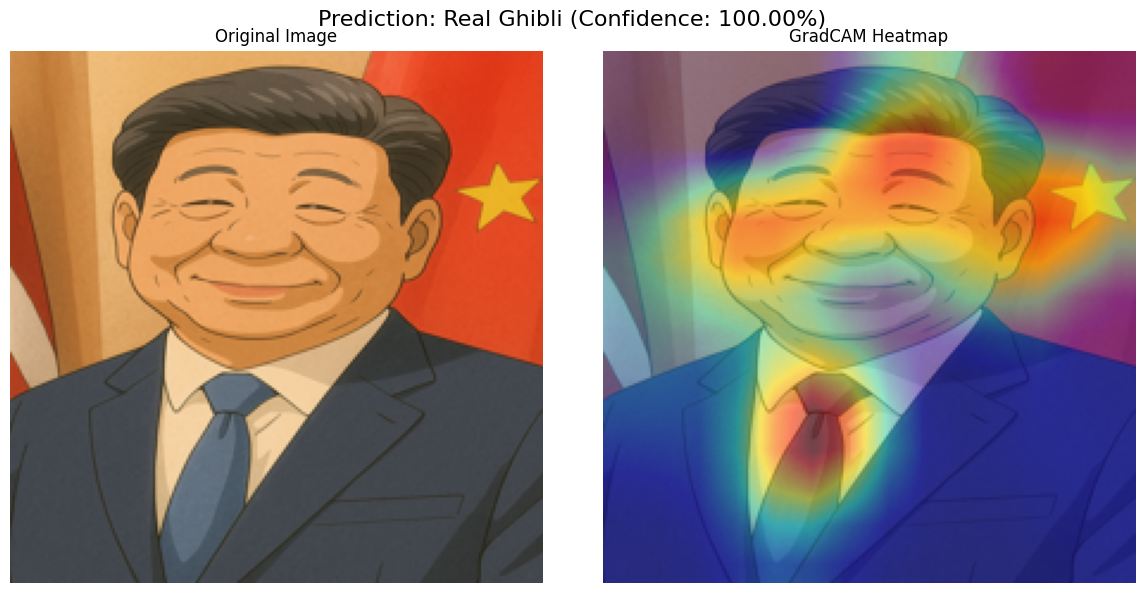

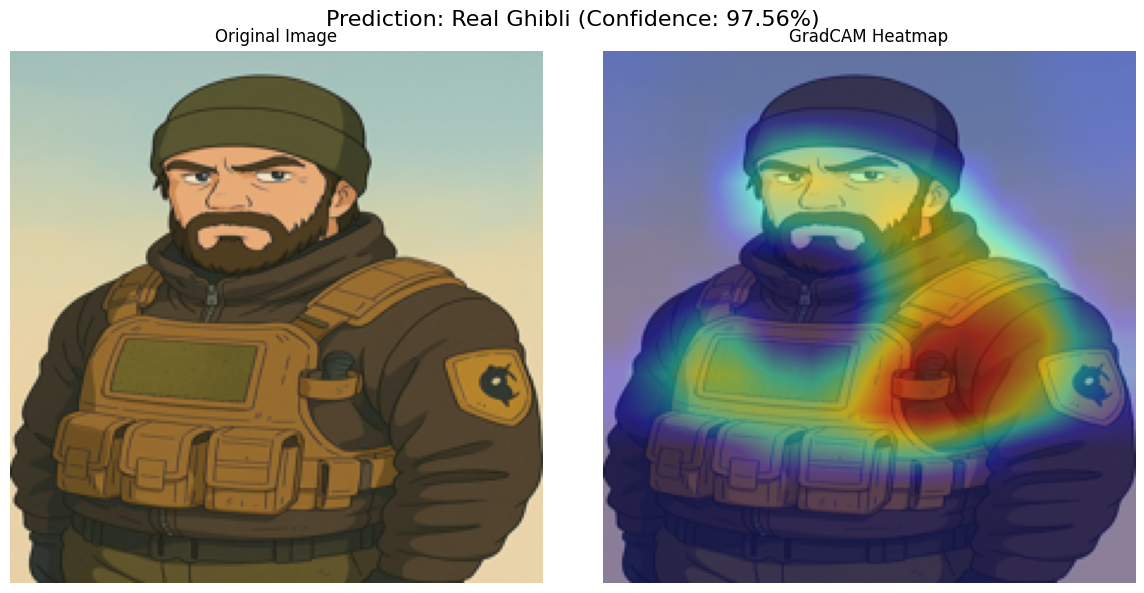

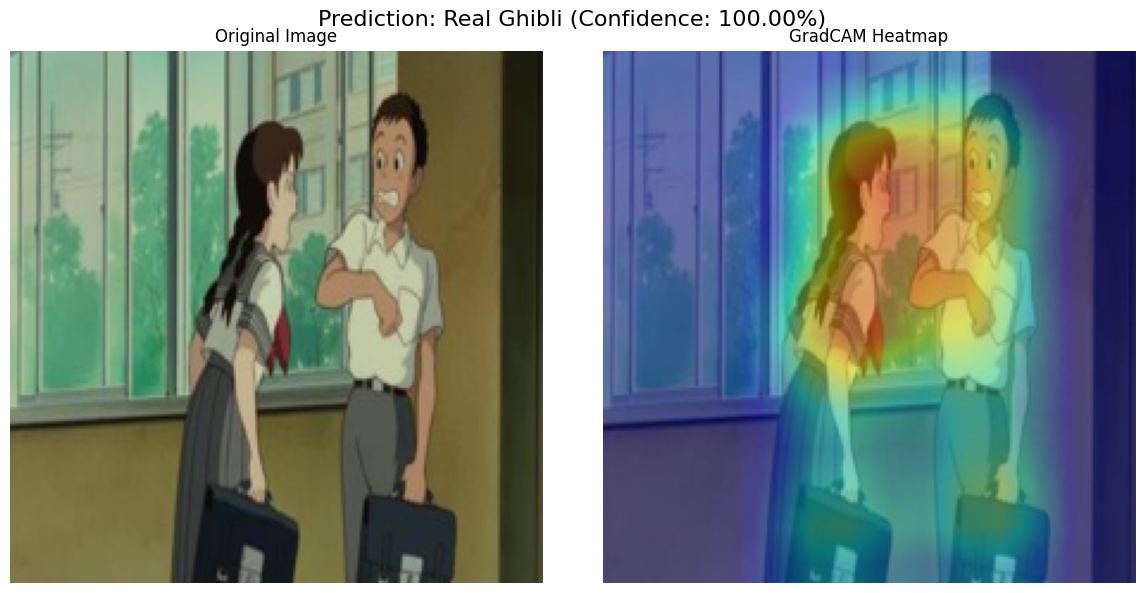

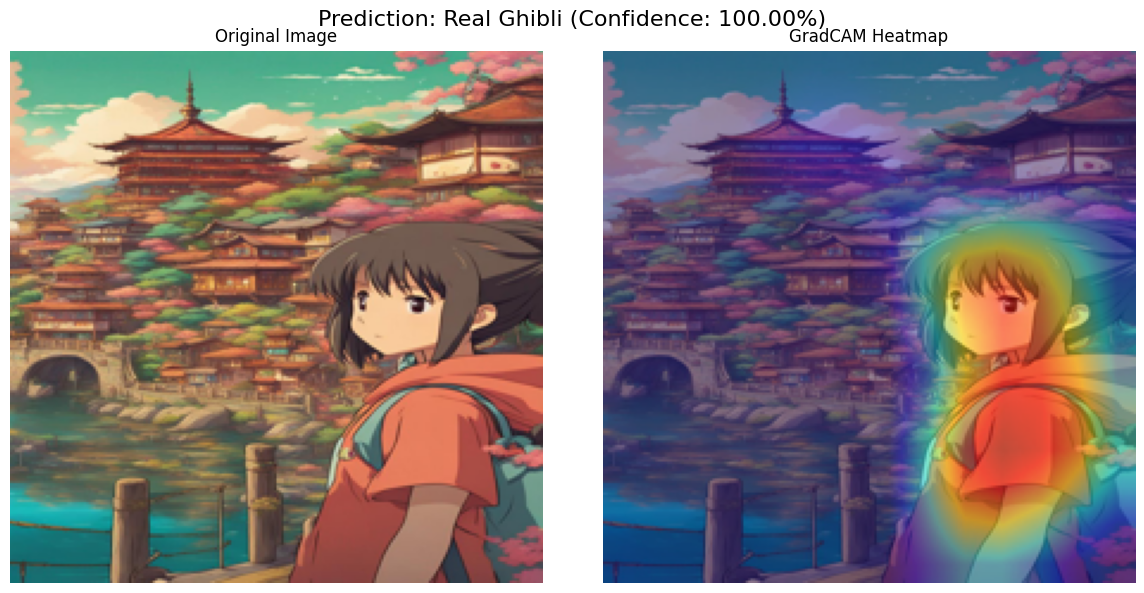

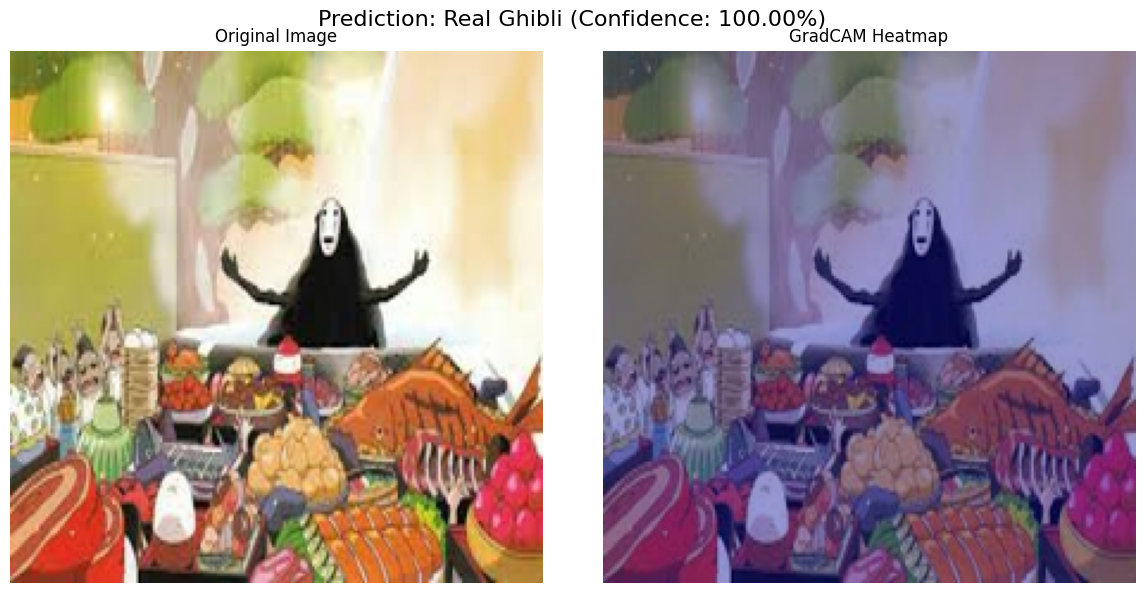

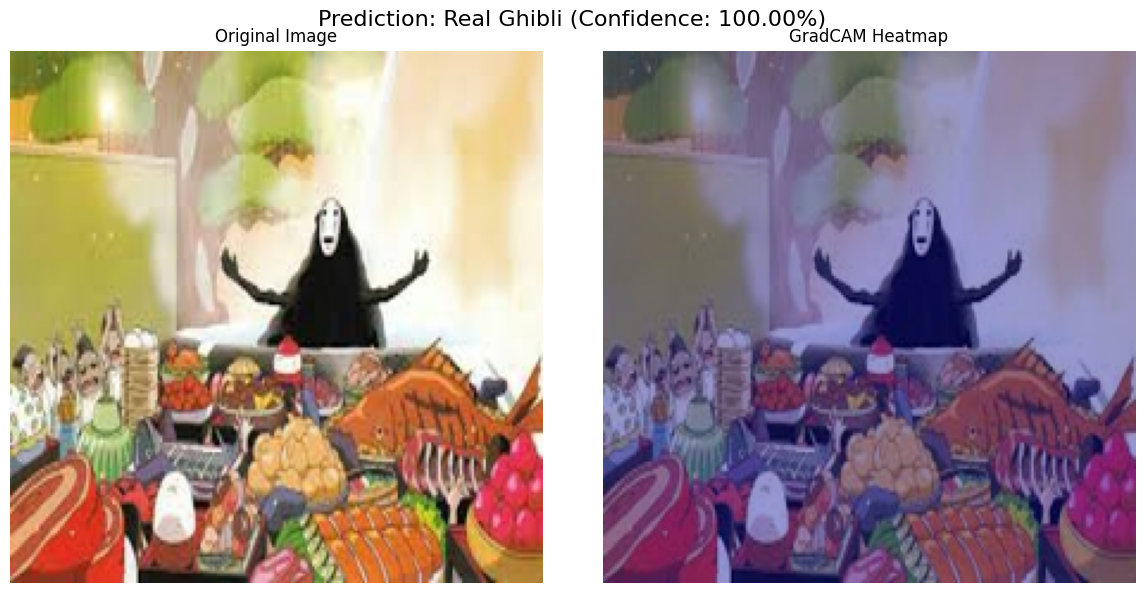

In [34]:
if __name__ == "__main__":
    # Prepare the datasets if they don't exist
    prepare_real_ghibli_images()
    prepare_ai_generated_images()

    # Setup data generators
    setup_data_generators()

    # Create directory for models
    if not os.path.exists("models"):
        os.makedirs("models")

    # Run the benchmark comparison of all models including enhanced Ghiblinosaurus
    results = benchmark_models()
    plot_benchmark_results(results)
    print("Benchmark Results:")
    print(results.sort_values('accuracy', ascending=False).to_string(index=False))
    results.to_csv("analysis/benchmark_results.csv", index=False)

In [35]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Constants
IMG_SIZE = 224

# Load model - try different paths
model_paths = [
    "/content/models/VGG16_best.h5",
    "/content/models/VGG16_final.h5",
    "models/VGG16_best.h5",
    "models/VGG16_final.h5"
]

# Try to load model
model = None
for path in model_paths:
    if os.path.exists(path):
        try:
            model = load_model(path)
            print(f"Successfully loaded model from {path}")
            break
        except Exception as e:
            print(f"Error loading model from {path}: {e}")

if model is None:
    print("Could not load any model. Please check the model paths.")
    # For debugging, create a simple model that returns 50/50 probability
    # This allows testing the rest of the interface
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.models import Model
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    outputs = Dense(2, activation='softmax')(Dense(10, activation='relu')(tf.keras.layers.Flatten()(inputs)))
    model = Model(inputs, outputs)
    print("Created a dummy model for testing purposes.")

# Verify model layers for GradCAM
def find_last_conv_layer(model):
    """Find the last convolutional layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or 'conv' in layer.name.lower():
            return layer.name
    return 'block5_conv3'  # Fallback for VGG16

# Get last conv layer name
last_conv_layer_name = find_last_conv_layer(model)
print(f"Using {last_conv_layer_name} for GradCAM visualization")

# Determine class indices from validation or test directory if available
# This ensures we get the correct mapping of indices to class names
def get_class_indices():
    test_dir = '/content/dataset/test'
    val_dir = '/content/dataset/val'
    train_dir = '/content/dataset/train'

    for directory in [test_dir, val_dir, train_dir]:
        if os.path.exists(directory):
            try:
                test_datagen = ImageDataGenerator(rescale=1./255)
                generator = test_datagen.flow_from_directory(
                    directory,
                    target_size=(IMG_SIZE, IMG_SIZE),
                    batch_size=1,
                    class_mode='categorical',
                    shuffle=False
                )
                return generator.class_indices
            except Exception as e:
                print(f"Couldn't determine class indices from {directory}: {e}")

    # Fallback - use the same order as in the training code
    print("Using default class indices")
    return {'ai_generated': 0, 'real_ghibli': 1}

# Get class indices and create mapping
class_indices = get_class_indices()
CLASS_NAMES = [None] * len(class_indices)
for class_name, idx in class_indices.items():
    CLASS_NAMES[idx] = class_name

print(f"Class indices: {class_indices}")
print(f"Class names mapped to indices: {CLASS_NAMES}")

def preprocess_image(img):
    """Preprocess an image for the model."""
    # Convert to RGB if needed
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize the image
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img)

    # Keep a copy of the original for display
    original_array = img_array.copy()

    # Normalize - use same preprocessing as during training
    processed_array = img_array / 255.0

    return original_array, processed_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Creates a heatmap from a model and an image array using Grad-CAM."""
    try:
        # Create a model that maps the input image to the activations
        # of the last conv layer and the output predictions
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        # Prepare input
        img_tensor = np.expand_dims(img_array, axis=0)

        # Compute gradients
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_tensor)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # Gradient of the predicted class with respect to the output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # Global average pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Weight the channels by the pooled gradients
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Normalize heatmap
        heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)

        return heatmap.numpy()

    except Exception as e:
        print(f"Error generating GradCAM: {e}")
        # Return a blank heatmap in case of error
        return np.zeros((img_array.shape[0], img_array.shape[1]))

def predict_and_visualize(input_image):
    """Predict class and create visualization."""
    if input_image is None:
        return None, "Please upload an image."

    try:
        # Convert from numpy to PIL if necessary
        if isinstance(input_image, np.ndarray):
            input_image = Image.fromarray(input_image.astype('uint8'))

        # Preprocess image
        original_array, processed_array = preprocess_image(input_image)

        # Make prediction
        img_tensor = np.expand_dims(processed_array, axis=0)
        prediction = model.predict(img_tensor)[0]

        # Log the raw prediction for debugging
        print(f"Raw prediction: {prediction}")
        print(f"Class names: {CLASS_NAMES}")

        # Get predicted class and confidence
        pred_class_idx = np.argmax(prediction)
        confidence = prediction[pred_class_idx] * 100
        pred_class = CLASS_NAMES[pred_class_idx]

        print(f"Predicted class index: {pred_class_idx}")
        print(f"Predicted class: {pred_class}")
        print(f"Confidence: {confidence:.2f}%")

        # Create GradCAM heatmap
        heatmap = make_gradcam_heatmap(processed_array, model, last_conv_layer_name, pred_class_idx)

        # Resize heatmap to match original image
        heatmap_resized = cv2.resize(heatmap, (original_array.shape[1], original_array.shape[0]))

        # Convert heatmap to RGB
        heatmap_rgb = np.uint8(255 * heatmap_resized)
        heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
        heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on original image
        superimposed = heatmap_rgb * 0.4 + original_array * 0.6
        superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)

        # Create a figure with the original image and heatmap overlay
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original image
        ax[0].imshow(original_array)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        # Heatmap overlay
        ax[1].imshow(superimposed)
        ax[1].set_title('GradCAM Heatmap')
        ax[1].axis('off')

        # Add prediction as a suptitle
        prediction_label = "AI-Generated" if pred_class == "ai_generated" else "Real Ghibli"
        fig.suptitle(f"Prediction: {prediction_label} (Confidence: {confidence:.2f}%)", fontsize=16)

        plt.tight_layout()

        # Generate explanation text
        if pred_class == "ai_generated":
            explanation = f"""
            ### Prediction: AI-Generated (Confidence: {confidence:.2f}%)

            The model has classified this image as **AI-generated** with {confidence:.2f}% confidence.

            The heatmap shows areas the model focused on to make this determination. AI-generated
            Ghibli-style images often have tell-tale signs like:

            - Unnatural line consistency
            - Unusual texture patterns
            - Inconsistent lighting or shading
            - Non-standard color palettes compared to authentic Ghibli

            *Raw model output: {prediction}*
            """
        else:
            explanation = f"""
            ### Prediction: Real Ghibli (Confidence: {confidence:.2f}%)

            The model has classified this image as a **real Ghibli artwork** with {confidence:.2f}% confidence.

            The heatmap shows areas the model focused on to make this determination. Authentic
            Ghibli artworks typically have:

            - Natural hand-drawn line work with slight variations
            - Consistent color palettes typical of Studio Ghibli
            - Characteristic texture patterns
            - Cohesive lighting and composition

            *Raw model output: {prediction}*
            """

        return fig, explanation

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        print(f"Error in prediction: {e}")
        print(error_details)
        return None, f"Error in prediction: {e}\n\n{error_details}"

# Add sample images for testing both classes
def find_sample_images():
    samples = []

    # Check first test directory
    test_dir = '/content/dataset/test'
    if os.path.exists(test_dir):
        for class_name in os.listdir(test_dir):
            class_dir = os.path.join(test_dir, class_name)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir)[:2]:  # Get first 2 images
                    img_path = os.path.join(class_dir, img_file)
                    if os.path.isfile(img_path):
                        samples.append(img_path)

    # If no samples found, check validation directory
    if not samples:
        val_dir = '/content/dataset/val'
        if os.path.exists(val_dir):
            for class_name in os.listdir(val_dir):
                class_dir = os.path.join(val_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_file in os.listdir(class_dir)[:2]:  # Get first 2 images
                        img_path = os.path.join(class_dir, img_file)
                        if os.path.isfile(img_path):
                            samples.append(img_path)

    return samples

sample_images = find_sample_images()
print(f"Found {len(sample_images)} sample images for examples")

# Create Gradio interface
demo = gr.Interface(
    fn=predict_and_visualize,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Plot(label="Model Prediction"),
        gr.Markdown(label="Explanation")
    ],
    title="Ghiblinosaurus: AI vs. Real Ghibli Classifier",
    description=f"""This tool uses a deep learning model to detect whether an image is AI-generated or authentic Studio Ghibli artwork.
                  Upload an image to see the prediction and visualization of what areas the model is focusing on.
                  Model loaded: {'✅' if model else '❌'} | Class mapping: {CLASS_NAMES}""",
    examples=sample_images,
    allow_flagging="never"
)

# Analyze a test image to verify model is working correctly
if sample_images:
    try:
        test_img = Image.open(sample_images[0])
        _, proc_img = preprocess_image(test_img)
        test_prediction = model.predict(np.expand_dims(proc_img, axis=0))[0]
        print(f"Test prediction on {sample_images[0]}: {test_prediction}")
        print(f"Predicted class: {CLASS_NAMES[np.argmax(test_prediction)]}")
        print(f"Confidence: {test_prediction[np.argmax(test_prediction)] * 100:.2f}%")
    except Exception as e:
        print(f"Error testing model: {e}")

# Launch the demo
demo.launch(share=True)

Successfully loaded model from /content/models/VGG16_best.h5
Using block5_conv3 for GradCAM visualization
Found 207 images belonging to 2 classes.
Class indices: {'ai_generated': 0, 'real_ghibli': 1}
Class names mapped to indices: ['ai_generated', 'real_ghibli']
Found 4 sample images for examples


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning:

The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Test prediction on /content/dataset/test/ai_generated/ai_generated_361.jpg: [1.1901134e-07 9.9999988e-01]
Predicted class: real_ghibli
Confidence: 100.00%
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://973fe26d7767953e17.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
